# Breast Cancer Analysis

# Imports

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


from sklearn.preprocessing import MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as sklearnPipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve as sklearn_roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier


# Functions

In [51]:
def check_nulls_dupes(df):
  print(f"The Amount of Null Values: {df.isna().sum()}")
  print(f"The Amount of Duplicated Values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 8))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 8))
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,4, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(20,20))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def histogram(df, interested_columns):
  
  plt.figure(figsize=(20,20))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    ax = plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=False, ax=ax, stat='density', bins=20, color='blue', label=f'Data Histogram for {col}')
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(df[col]), np.std(df[col]))
    ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
    
    title = f"{col}: mu = {np.mean(df[col]):.2f}, std = {np.std(df[col]):.2f}"
    ax.set_title(title)
    ax.legend()
  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

# EDA Analysis

In [15]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010              0.14710   
1            0.08474           0.07864         0.08690              0.07017   
2            0.10960           0.15990         0.19740              0.12790   
3            0.14250           0.28390         0.24140              0.10520   
4            0.10030           0.13280         0.19800              0.10430   
..               ...               ...             ...                  ...   
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0    ...          17.33           184.60      2019.0           0.16220   
1    ...          23.41           158.80      1956.0           0.12380   
2    ...          25.53           152.50      1709.0           0.14440   
3    ...          26.50            98.87       567.7           0.20980   
4    ...          16.67           152.20      1575.0           0.13740   
..   ...            ...              ...         ...               ...   
564  ...          26.40           166.10      2027.0           0.14100   
565  ...          38.25           155.00      1731.0           0.11660   
566  ...          34.12           126.70      1124.0           0.11390   
567  ...          39.42           184.60      1821.0           0.16500   
568  ...          30.37            59.16       268.6           0.08996   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0              0.66560           0.7119                0.2654          0.4601   
1              0.18660           0.2416                0.1860          0.2750   
2              0.42450           0.4504                0.2430          0.3613   
3              0.86630           0.6869                0.2575          0.6638   
4              0.20500           0.4000                0.1625          0.2364   
..                 ...              ...                   ...             ...   
564            0.21130           0.4107                0.2216          0.2060   
565            0.19220           0.3215                0.1628          0.2572   
566            0.30940           0.3403                0.1418          0.2218   
567            0.86810           0.9387                0.2650          0.4087   
568            0.06444           0.0000                0.0000          0.2871   

     fractal_dimension_worst  Unnamed: 32  
0                    0.11890          NaN  
1                    0.08902          NaN  
2                    0.08758          NaN  
3                    0.17300          NaN  
4      

# Check For Nulls and Dupes

In [4]:
check_nulls_dupes(df)

The Amount of Null Values: id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dime

In [16]:
df.drop(['Unnamed: 32', "id"], axis=1, inplace=True)

# Check Class Imbalance

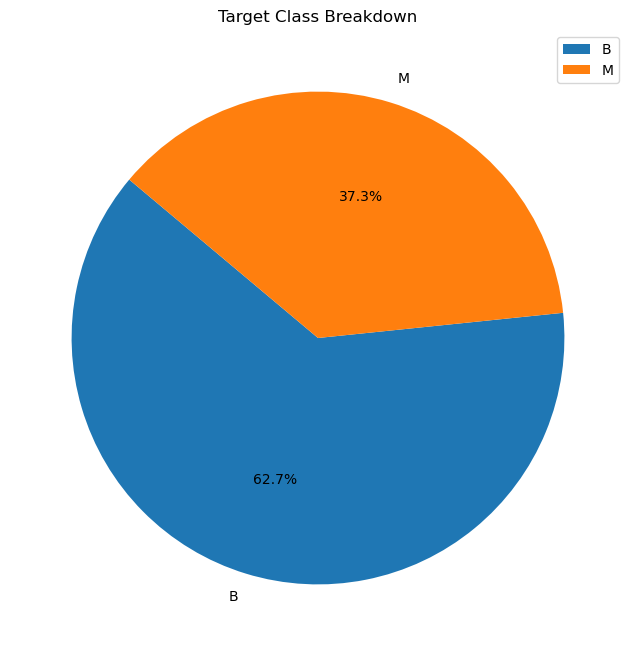

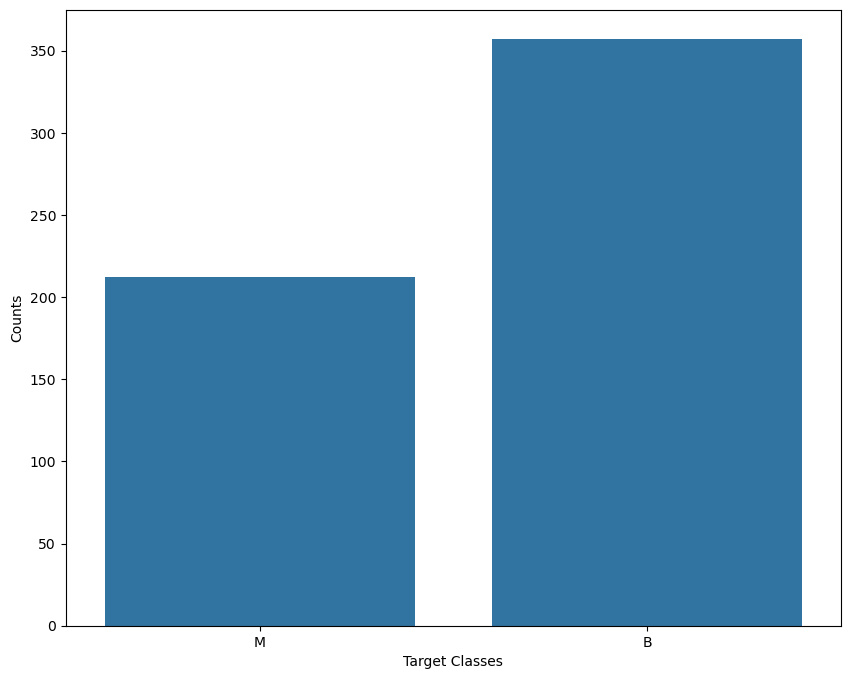

In [6]:
check_class_imbalance(df["diagnosis"])

# Class Imbalance

In [8]:
df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [9]:
df.describe()

id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
count     569.000000  ...    569.000000     569.000000       569.000000   
mean        0.181162  ...     16.269190      25.677223       107.261213   
std         0.027414  ...      4.833242       6.146258        33.602542   
min         0.106000  ...      7.930000      12.020000        50.410000   
25%         0.161900  ...     13.010000      21.080000        84.110000   
50%         0.179200  ...     14.970000      25.410000        97.660000   
75%         0.195700  ...     18.790000      29.720000       125.400000   
max         0.304000  ...     36.040000      49.540000       251.200000   

        area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count   569.000000        569.000000         569.000000       569.000000   
mean    880.583128          0.132369           0.254265         0.272188   
std     569.356993          0.022832           0.157336         0.208624   
min     185.200000          0.071170           0.027290         0.000000   
25%     515.300000          0.116600           0.147200         0.114500   
50%     686.500000          0.131300           0.211900         0.226700   
75%    1084.000000          0.146000           0.339100         0.382900   
max    4254.000000          0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500  

[8 rows x 31 columns]

# Heatmap

In [17]:
eda_df = df.copy()

eda_df["diagnosis"] = eda_df["diagnosis"].apply(lambda x: 1 if x == "M" else 0)

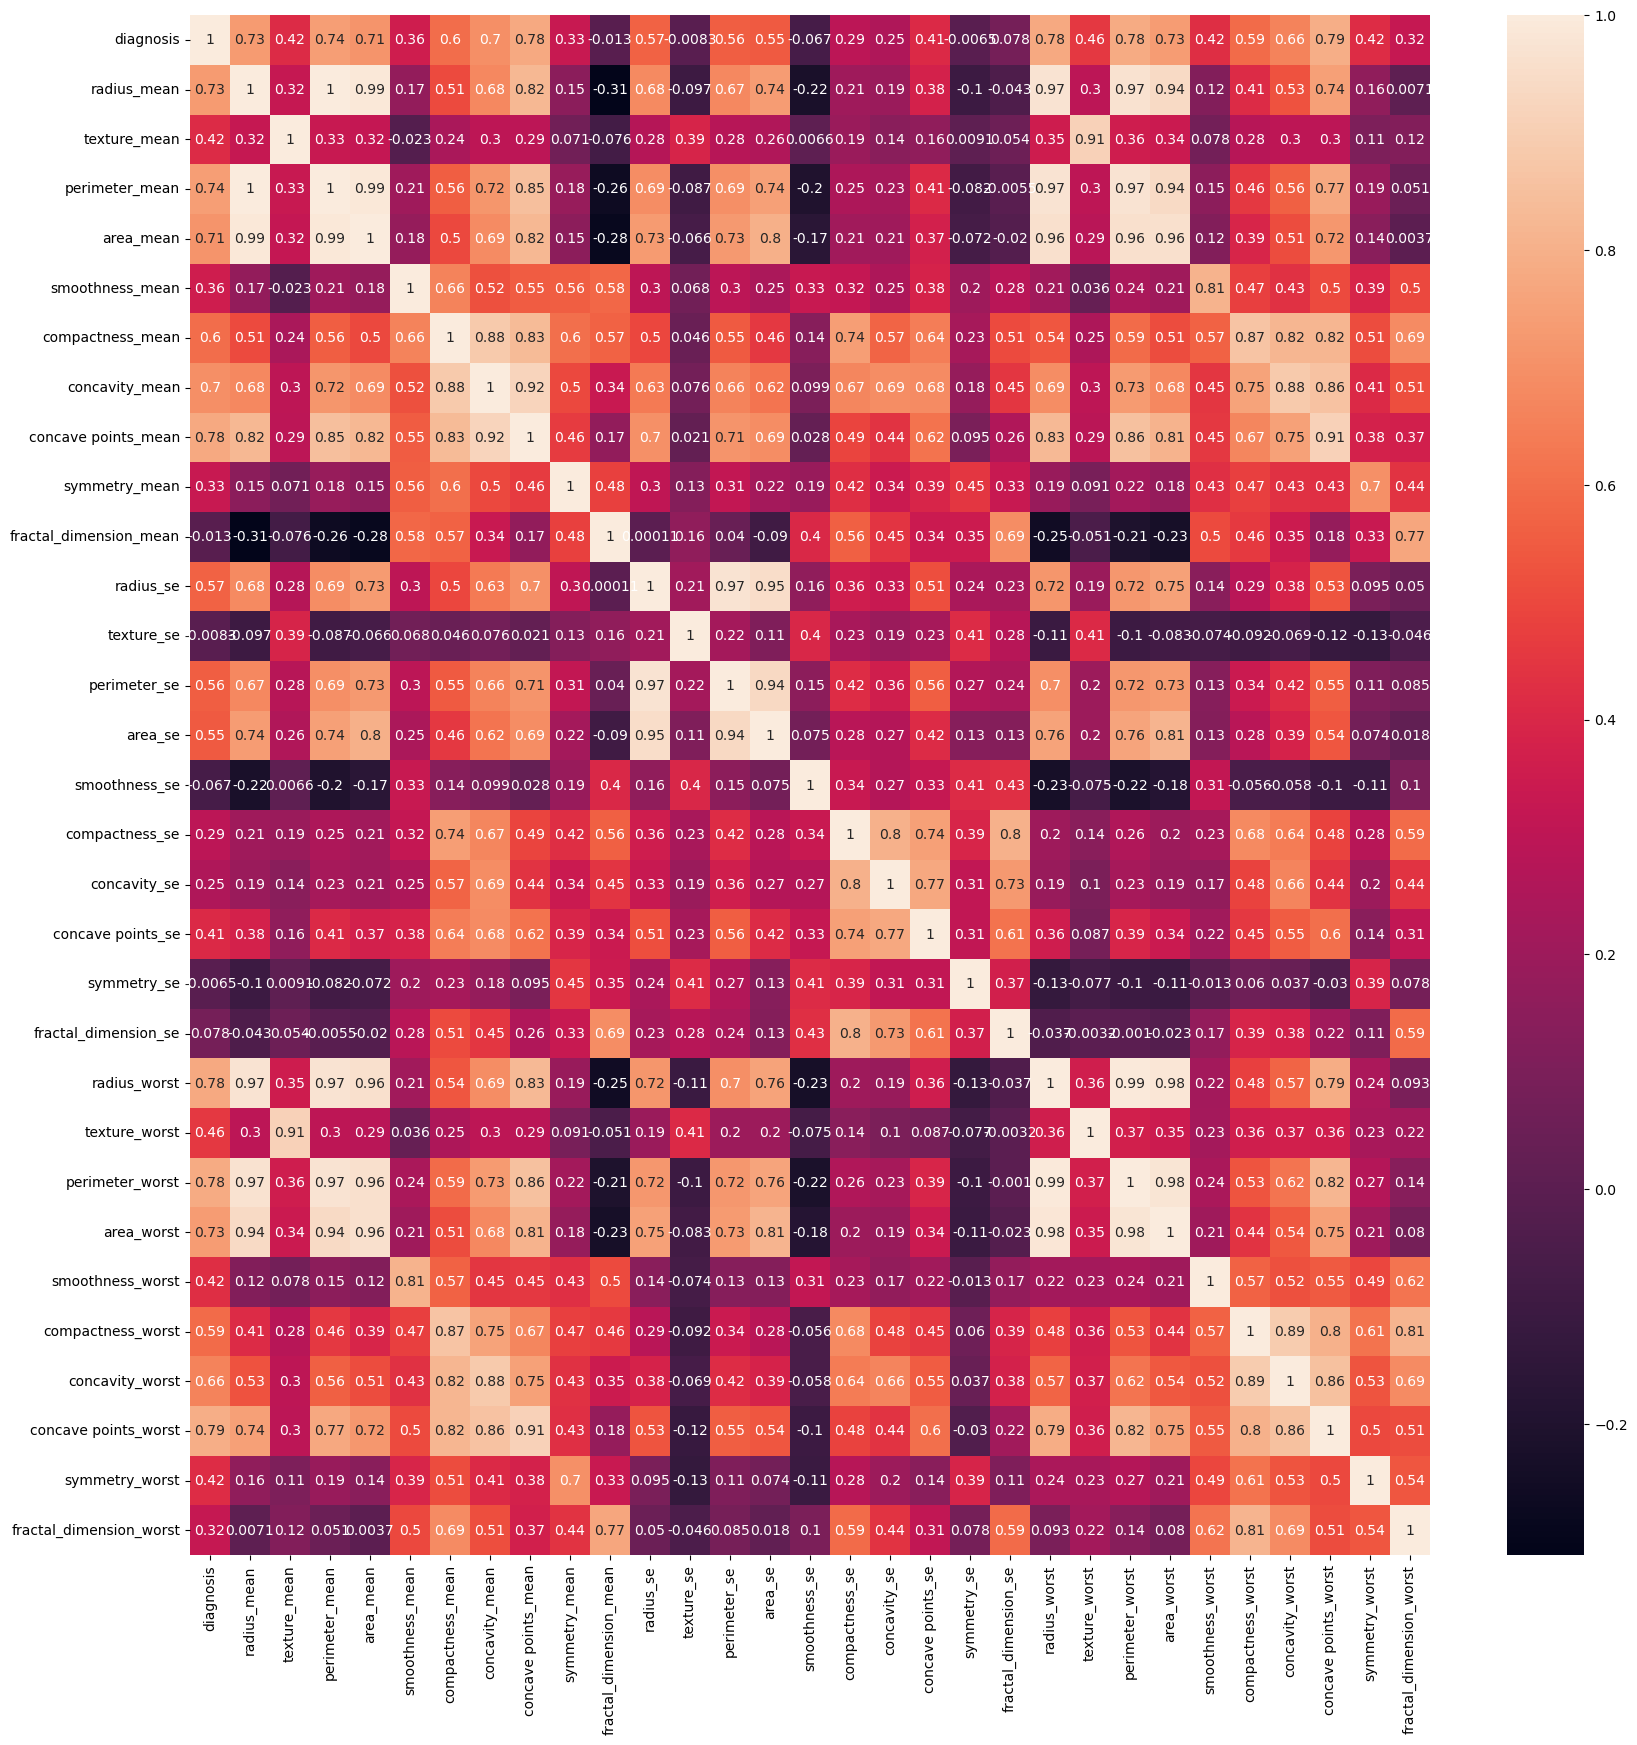

In [18]:
relations = eda_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(data=relations, annot=True)
plt.show()

# Histogram

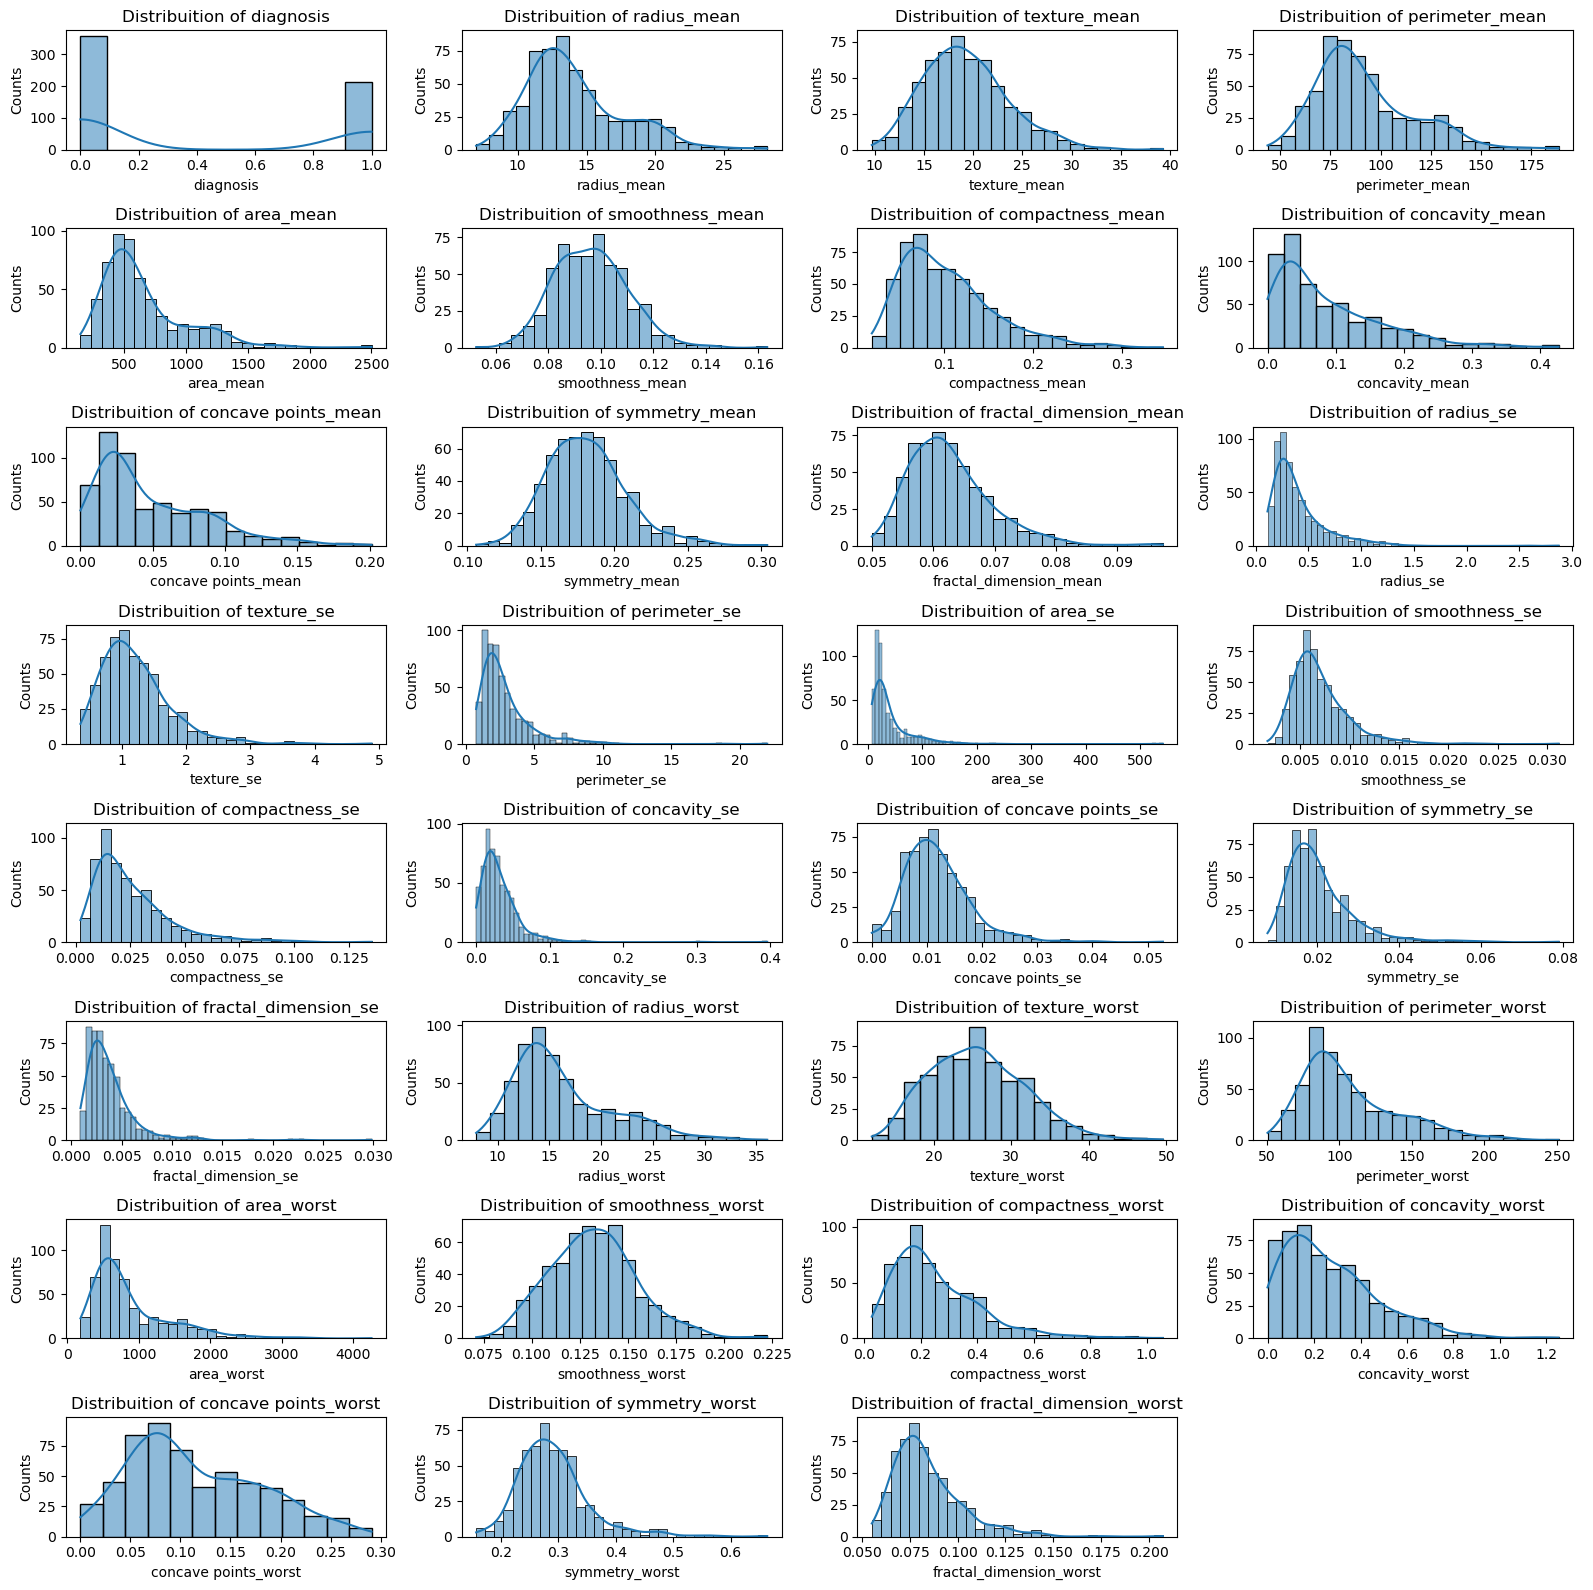

In [19]:
plot_distribution(eda_df, "hist")

# Box Plot

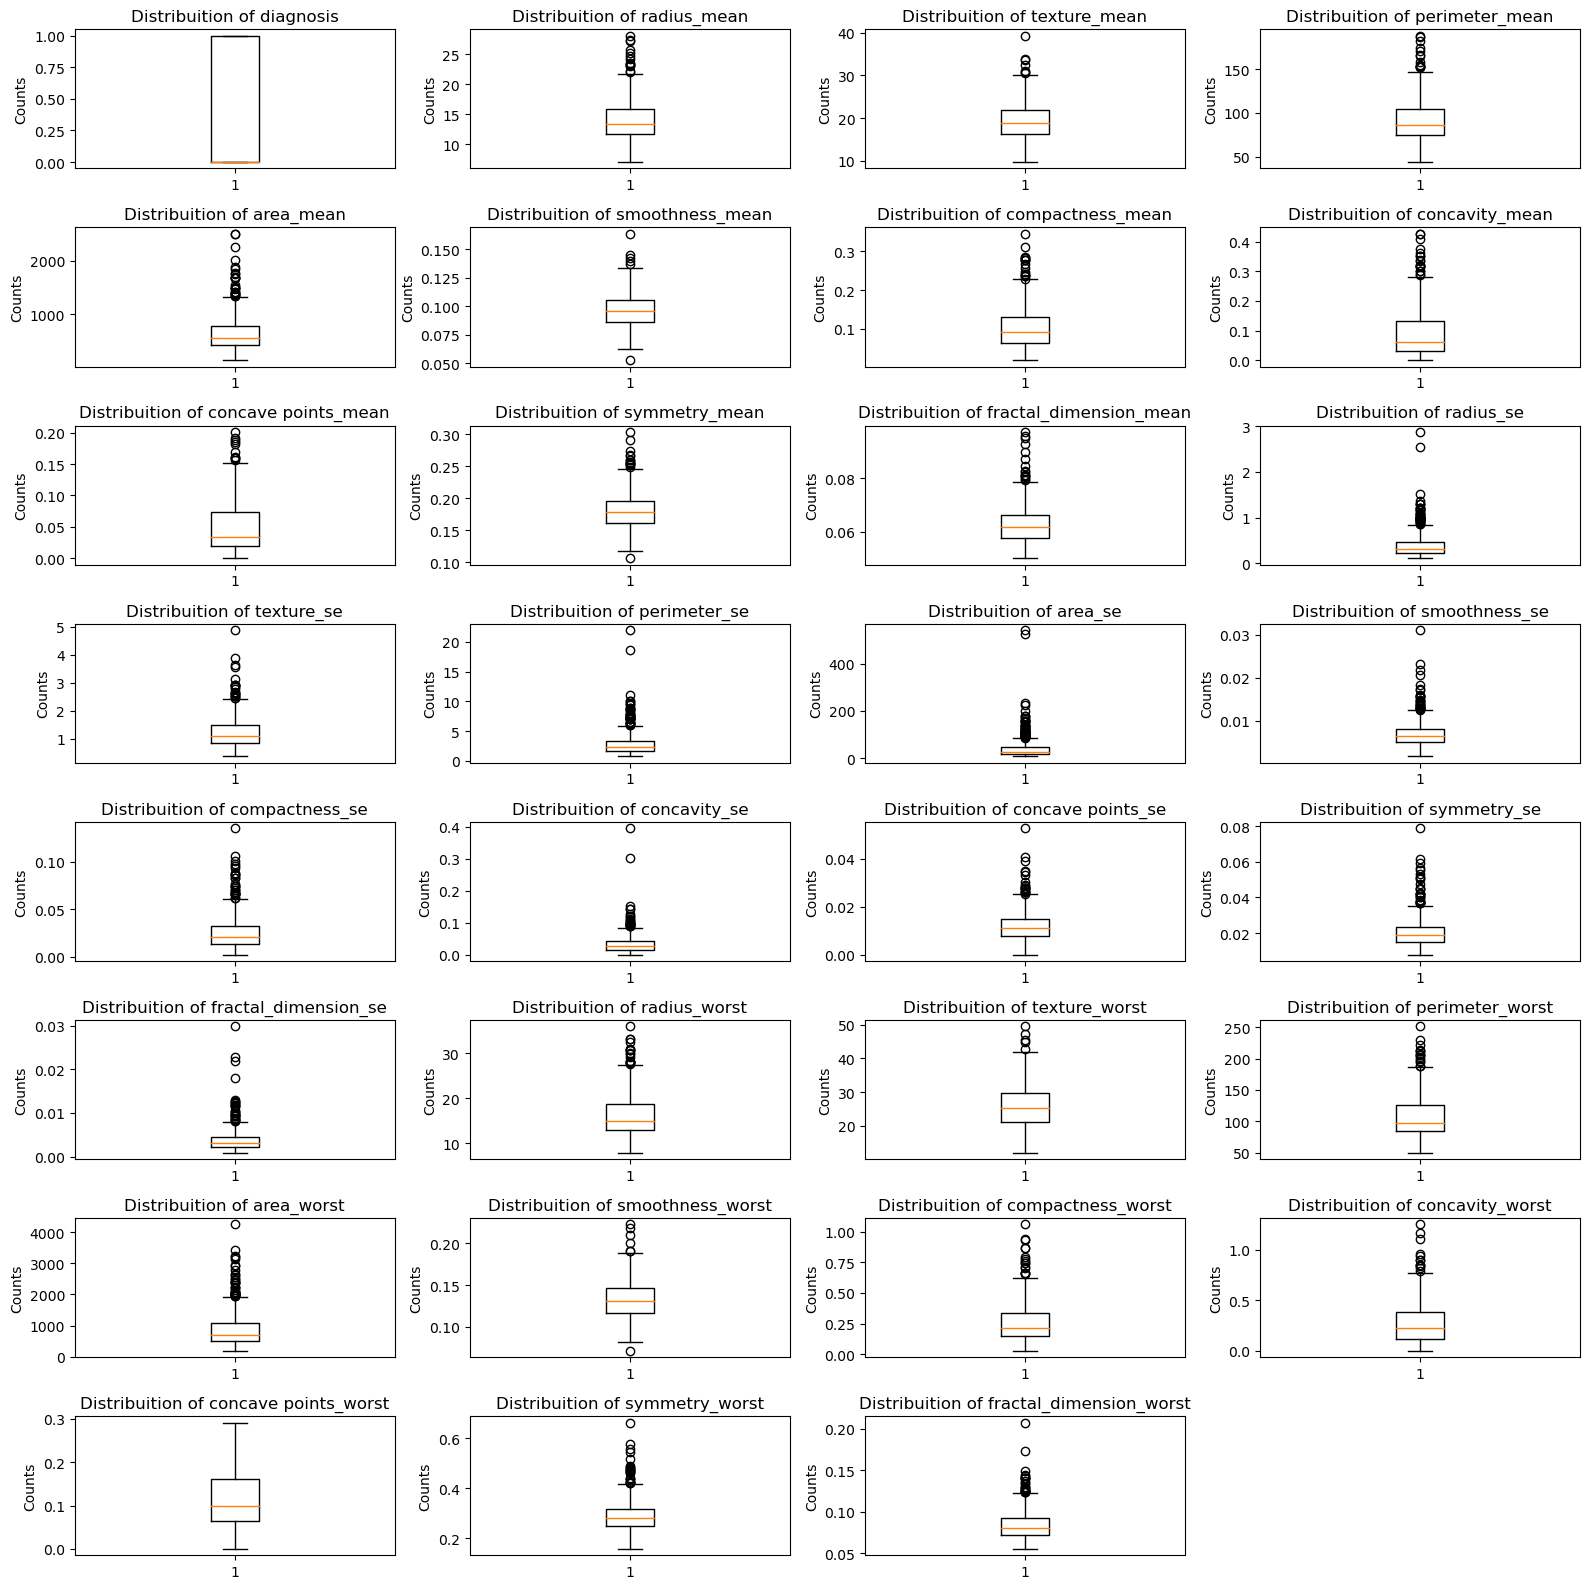

In [47]:
plot_distribution(eda_df, "box")

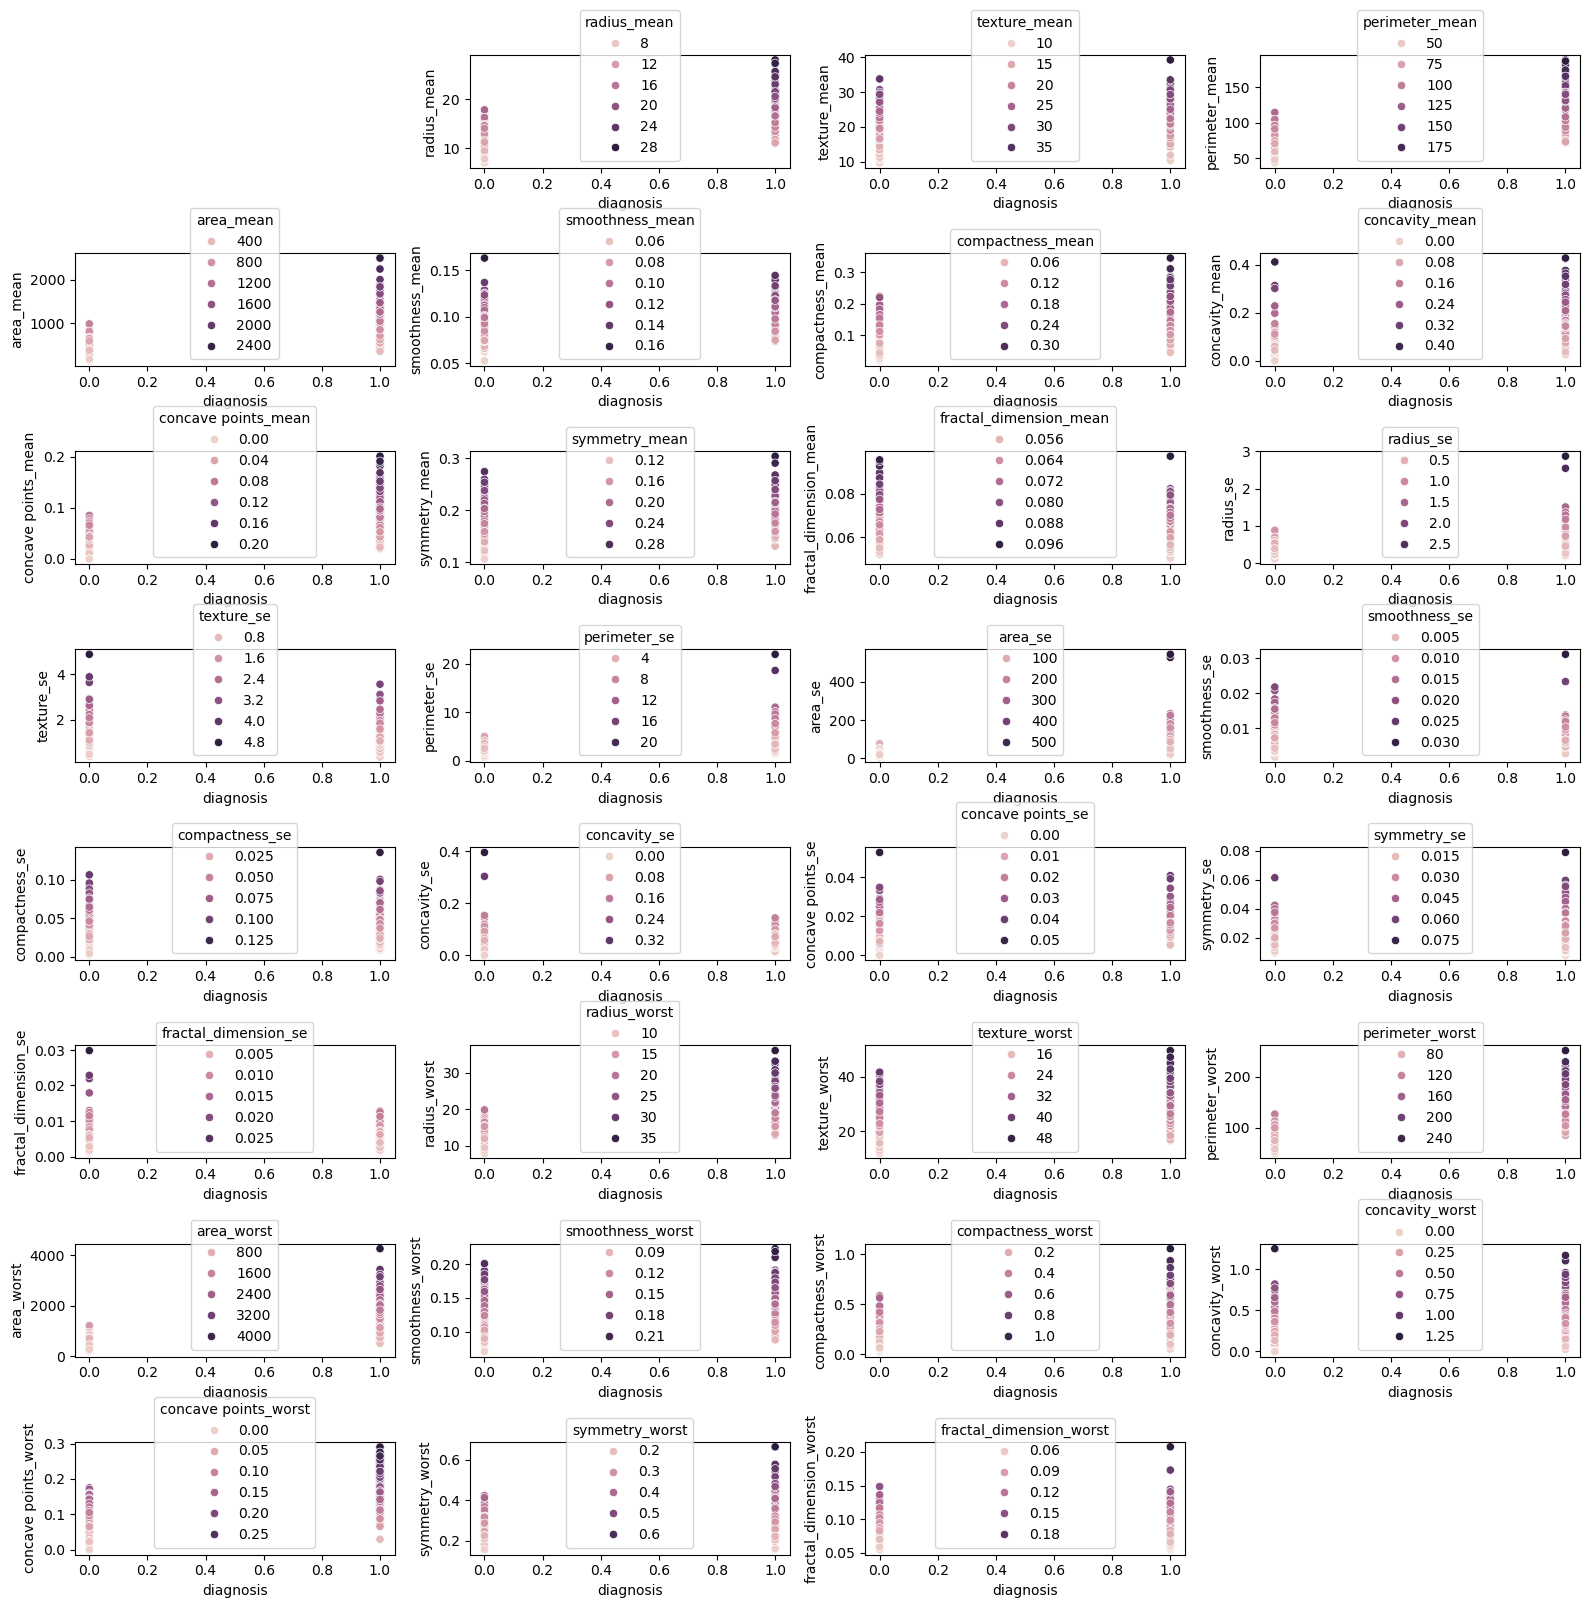

In [24]:
scatter_plot(eda_df, eda_df.columns, "diagnosis")

In [28]:
interested_columns = [col for col in eda_df.columns if col != "diagnosis"]

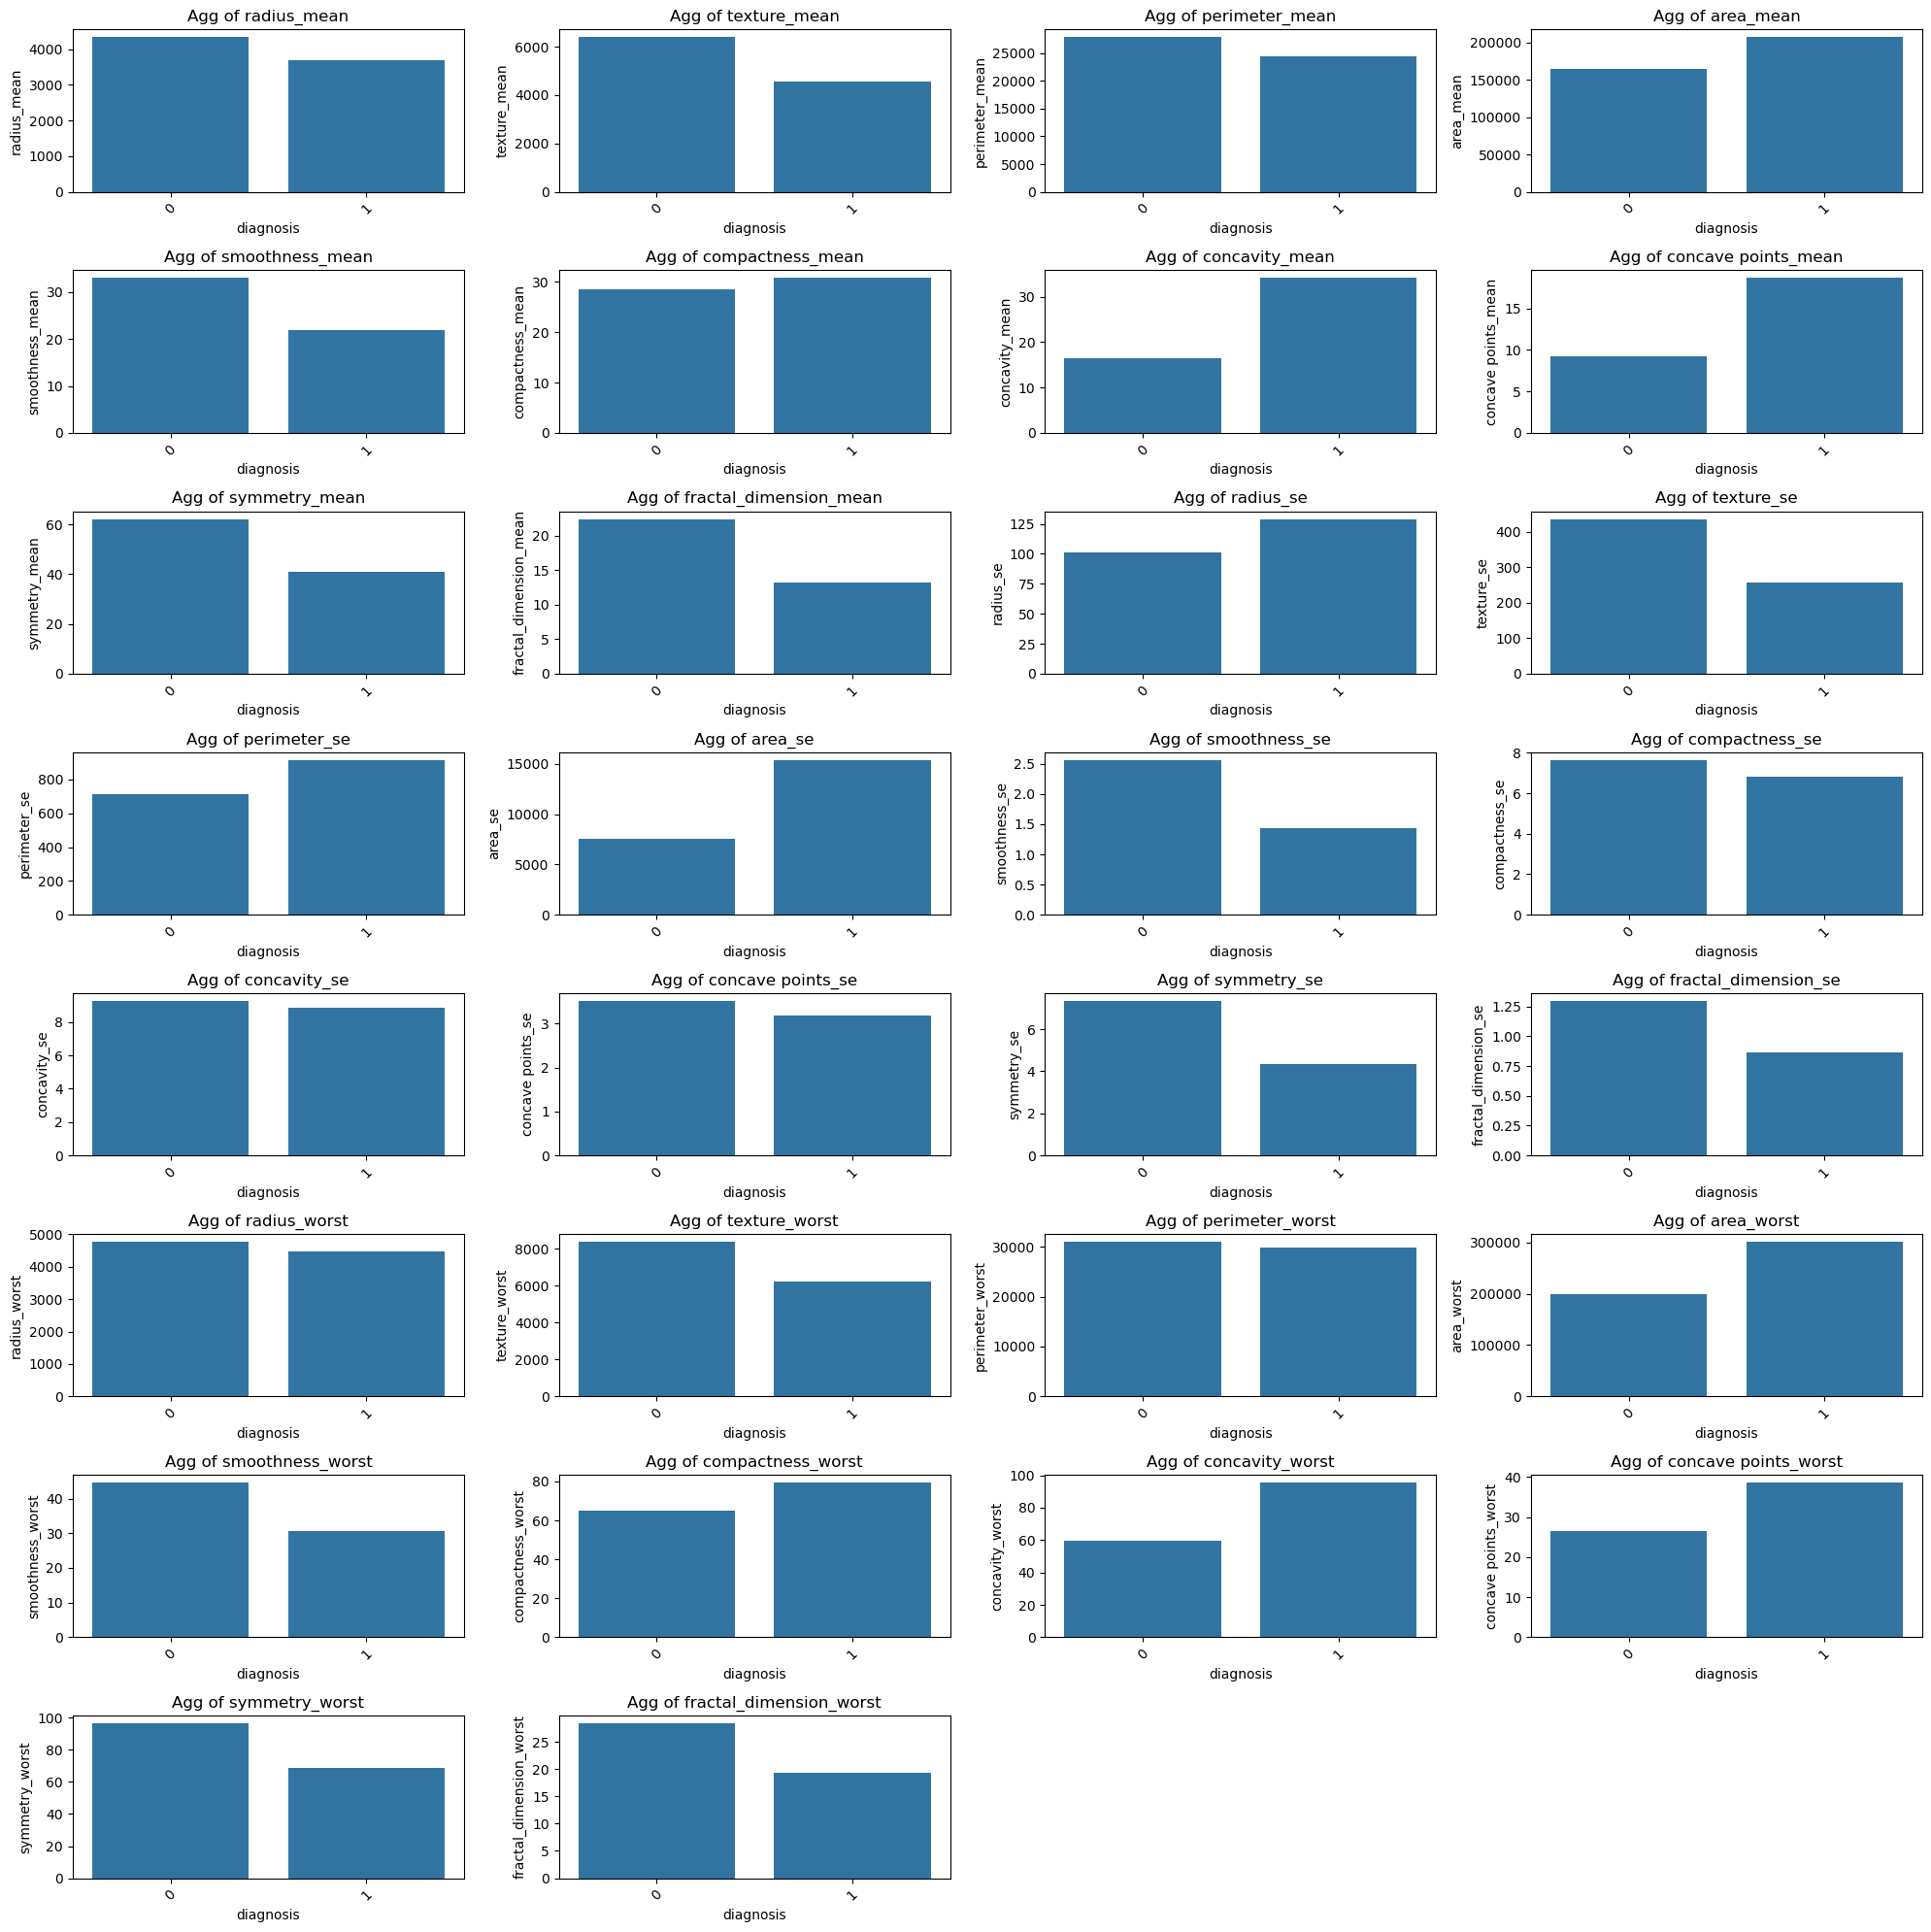

In [33]:
aggregate_dataset(eda_df, interested_columns, "diagnosis", "sum")

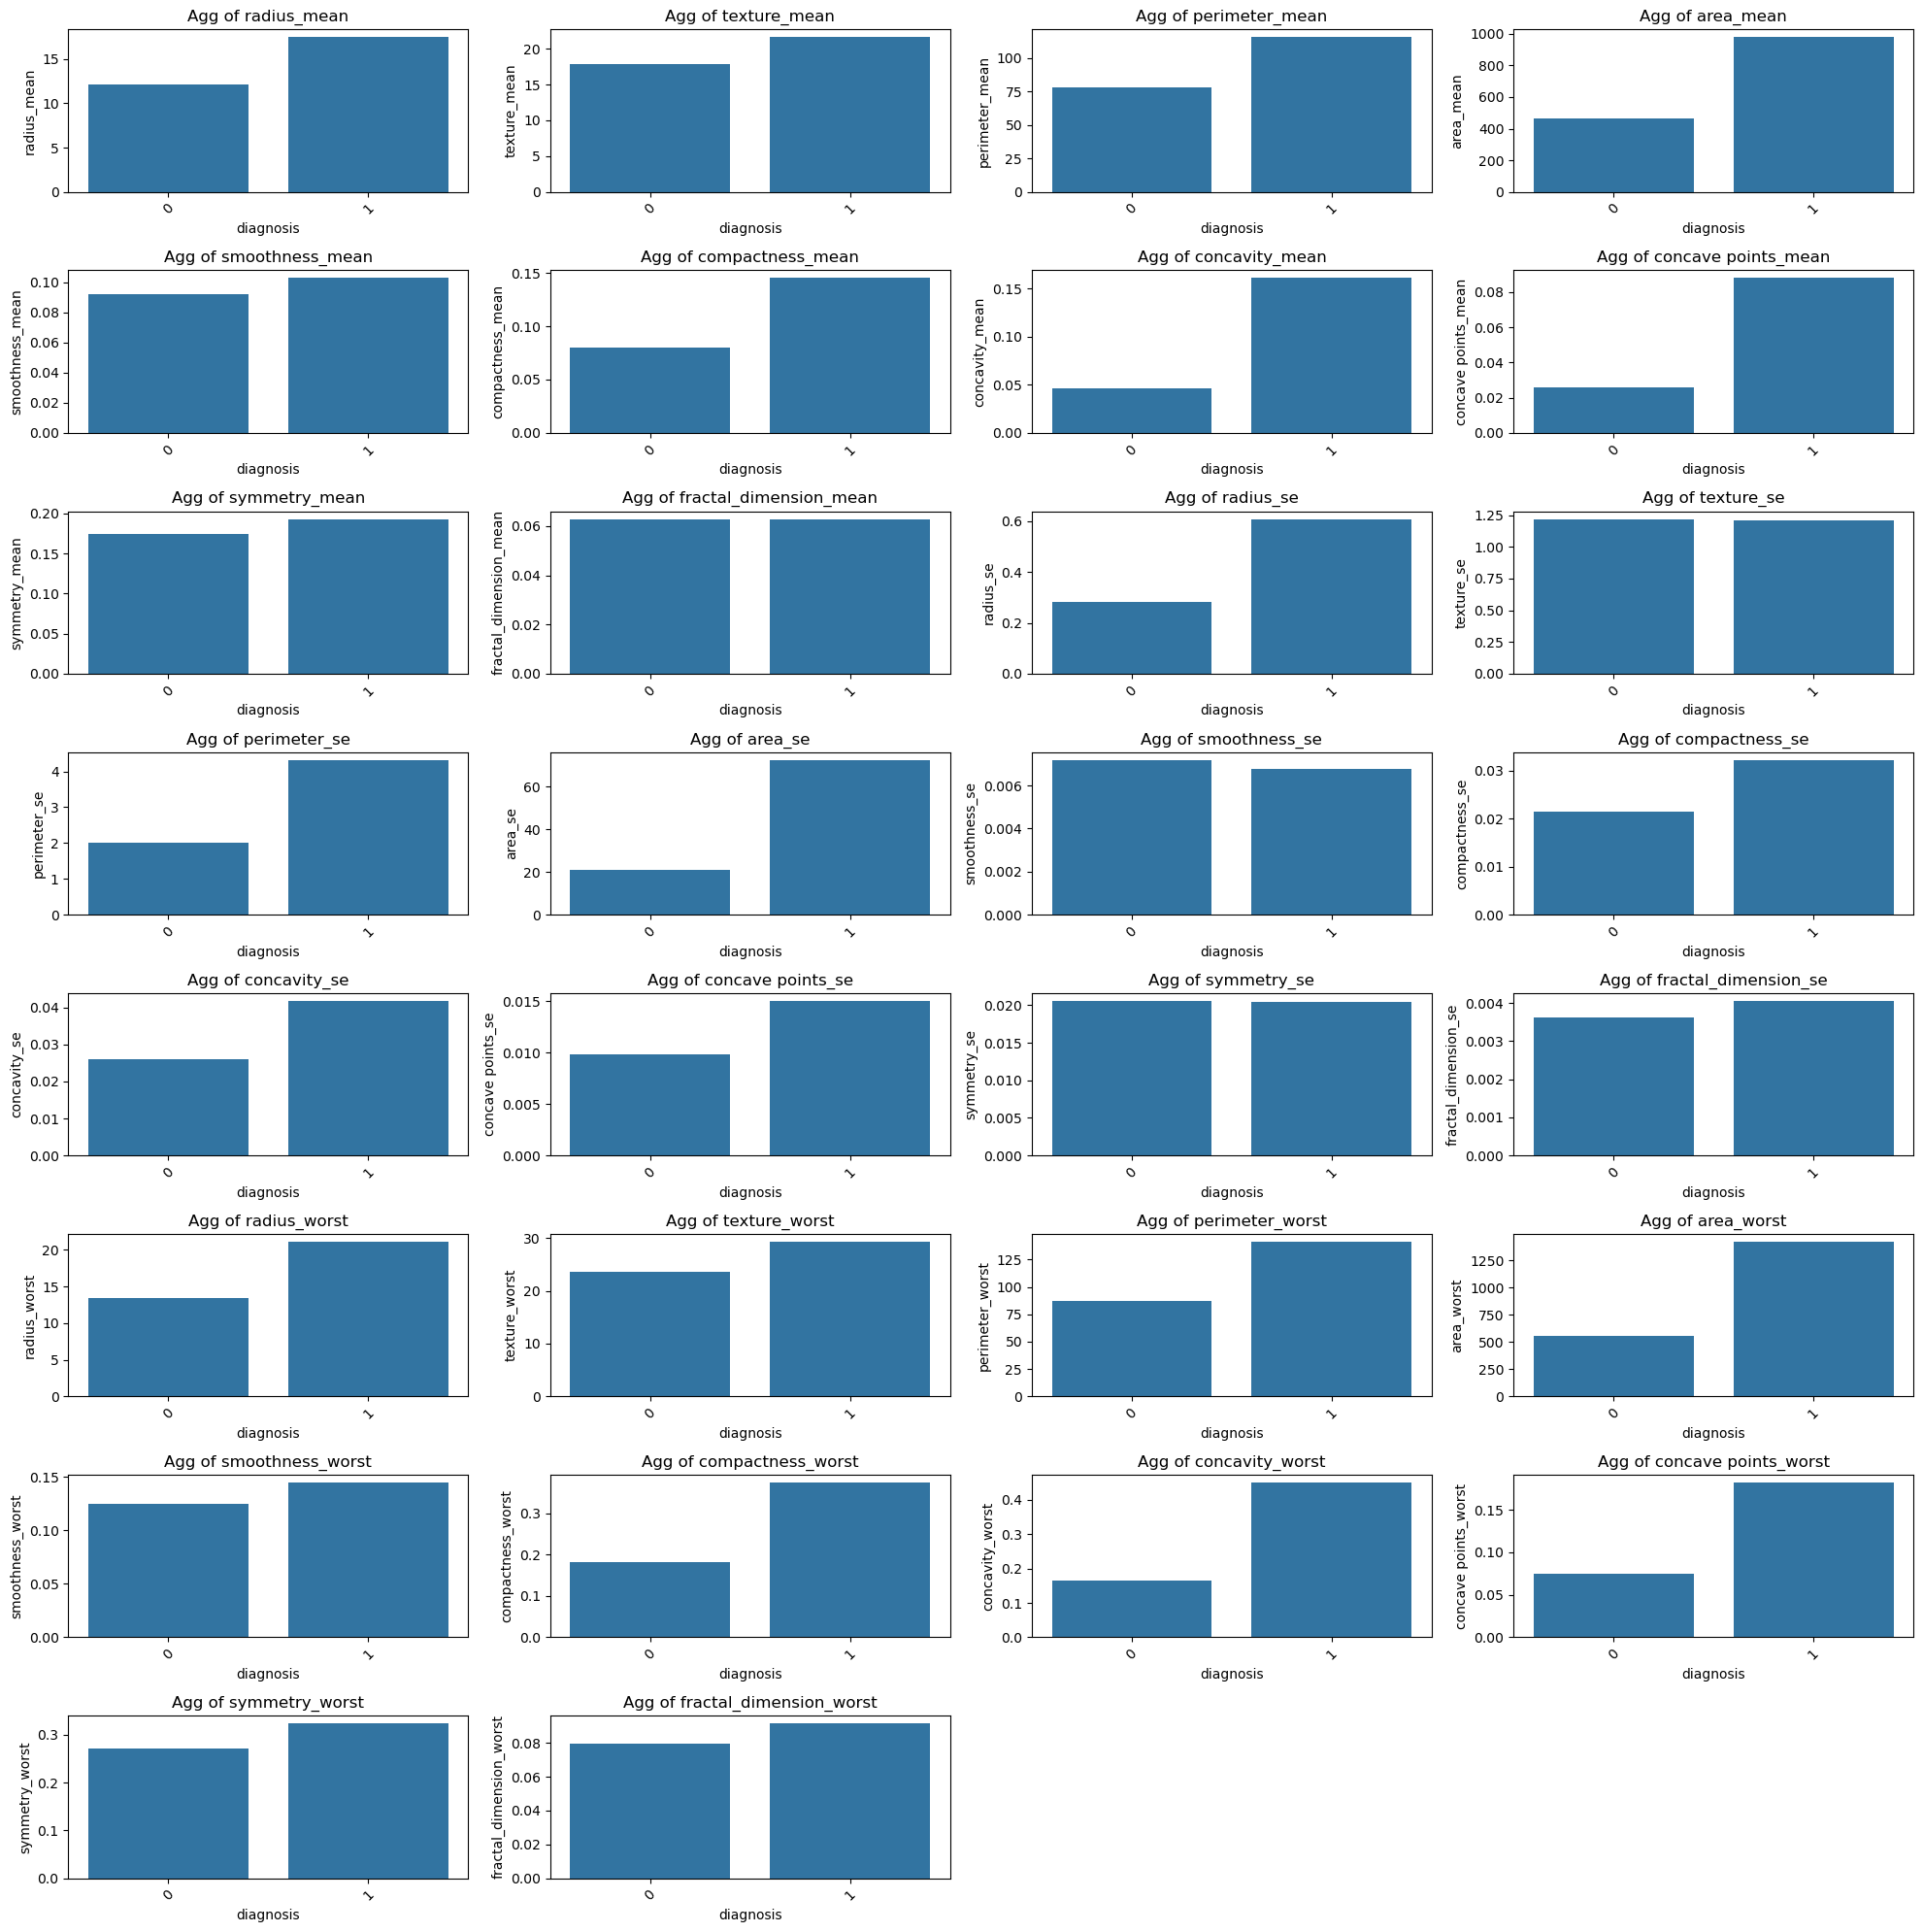

In [34]:
aggregate_dataset(eda_df, interested_columns, "diagnosis", "mean")

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_31023/3154466754.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_31023/3154466754.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_31023/3154466754.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folde

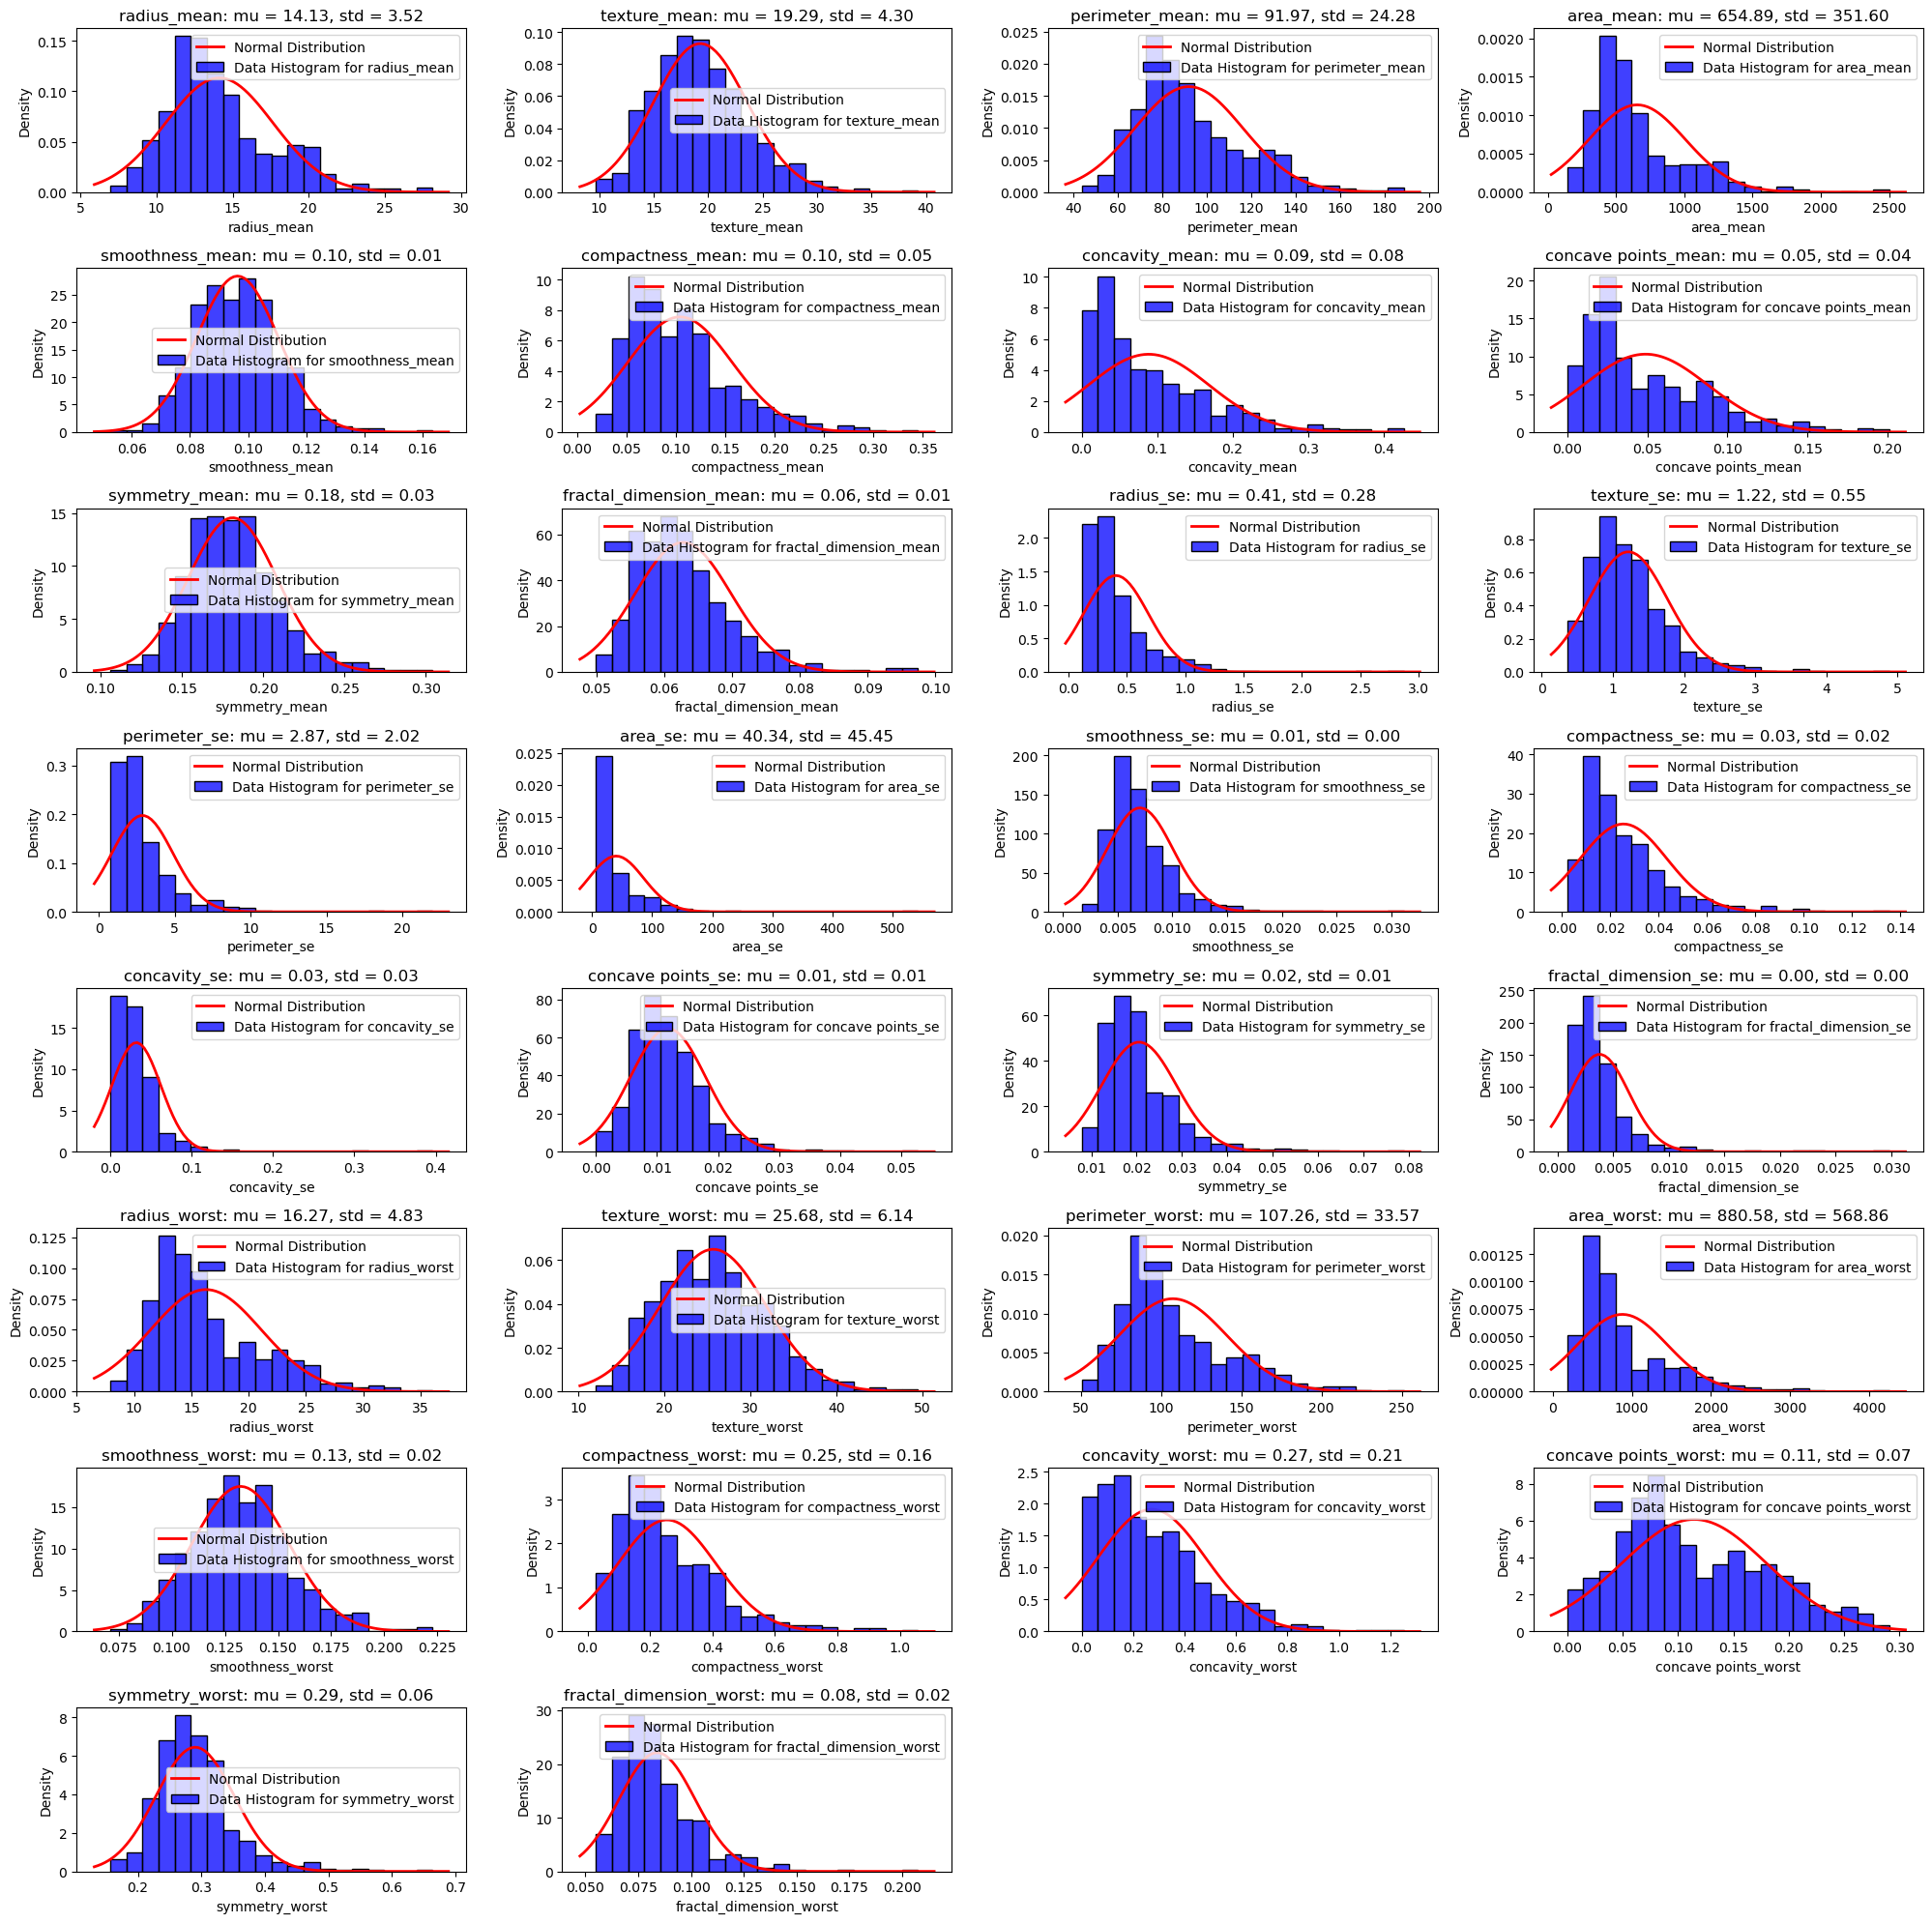

In [46]:
histogram(eda_df, interested_columns)

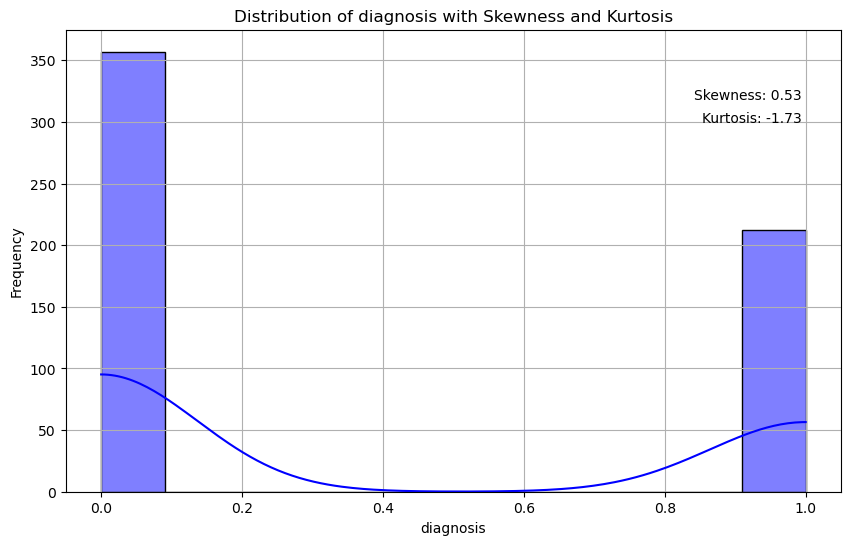

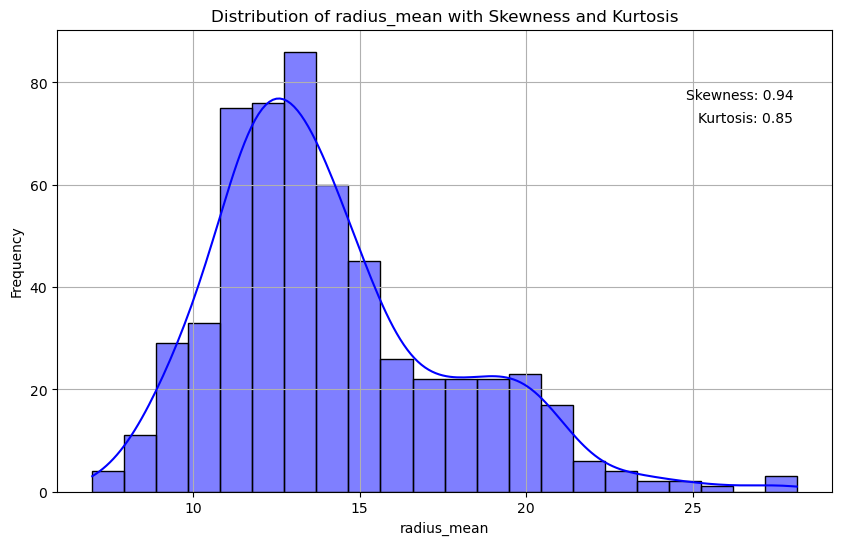

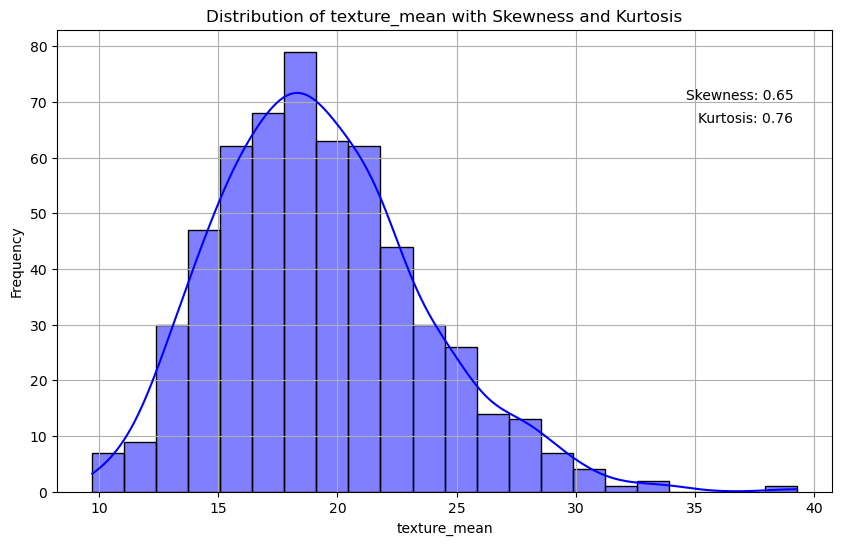

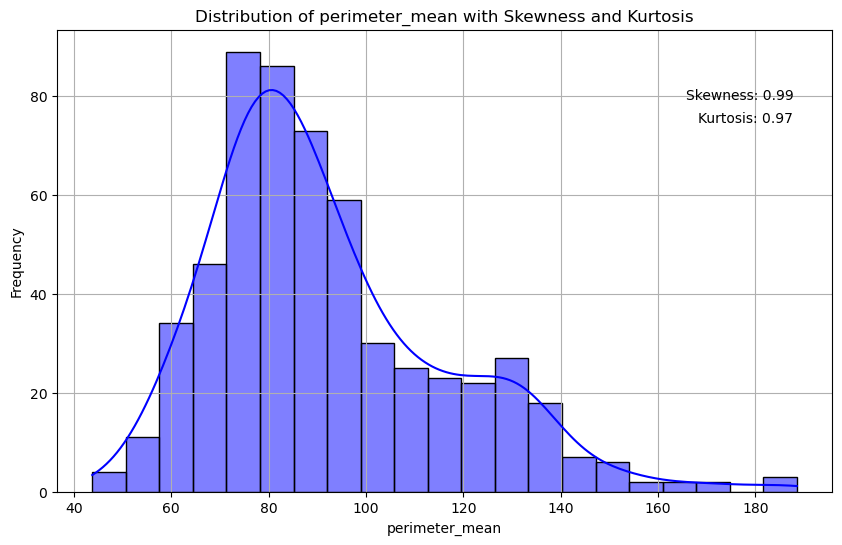

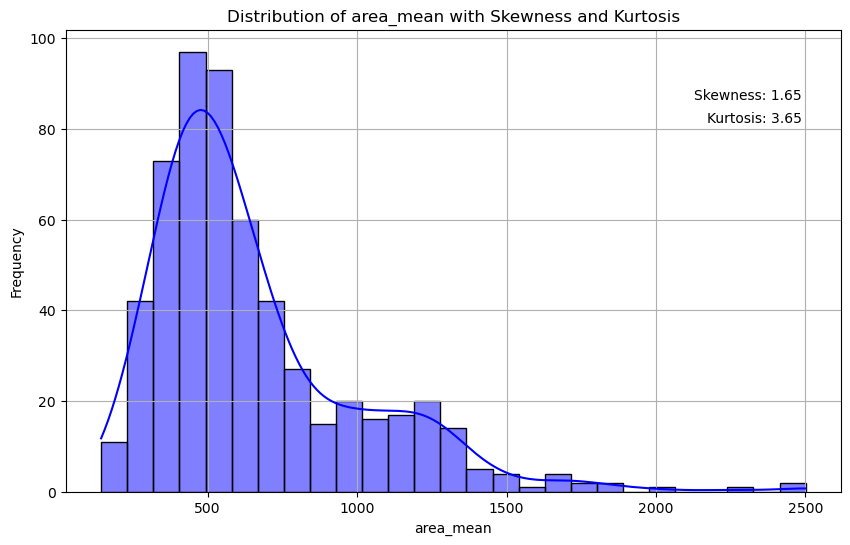

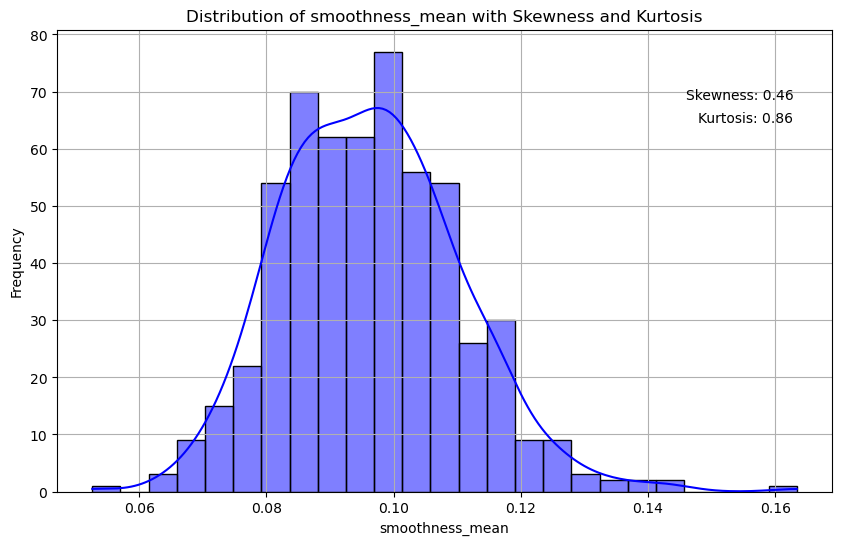

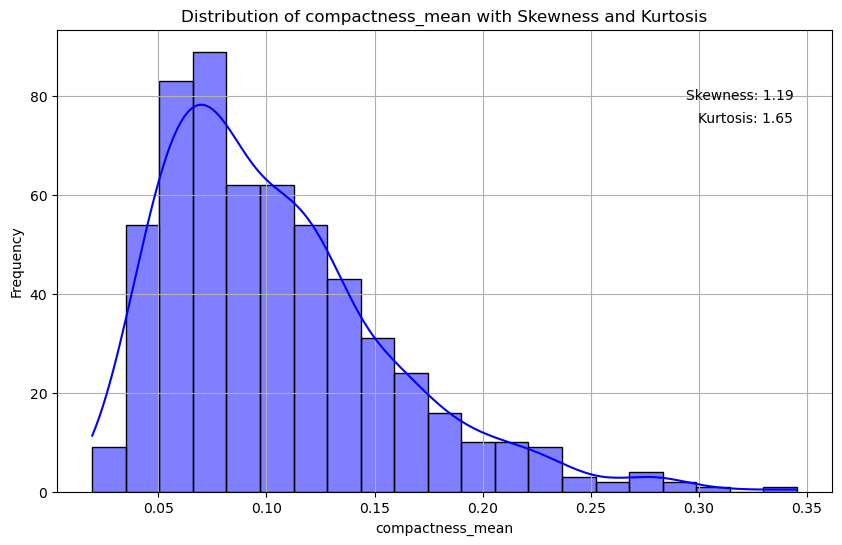

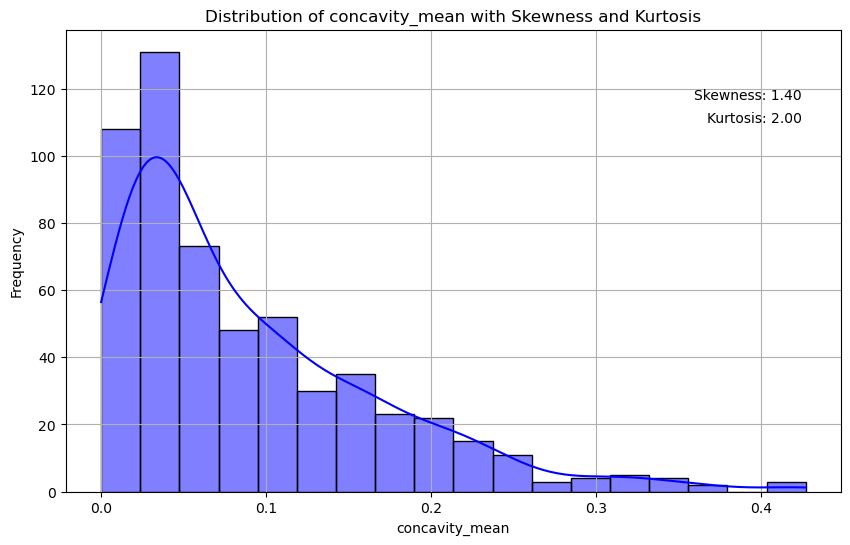

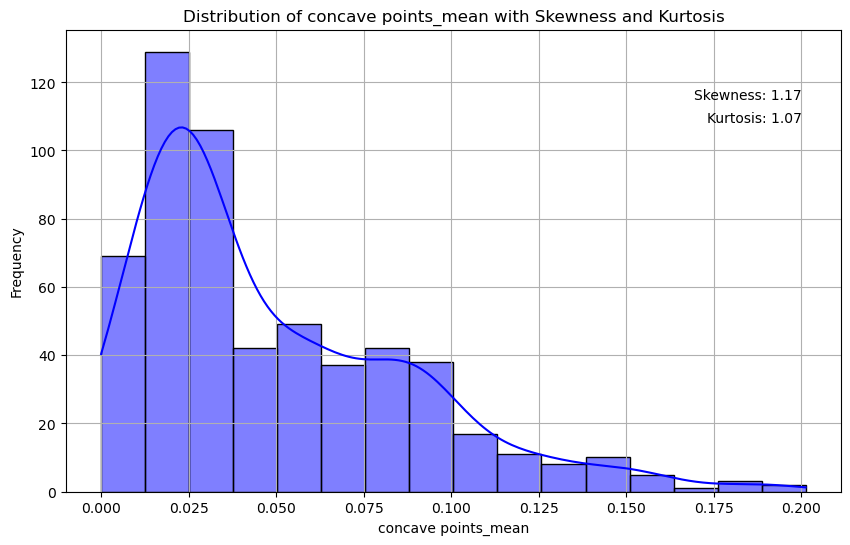

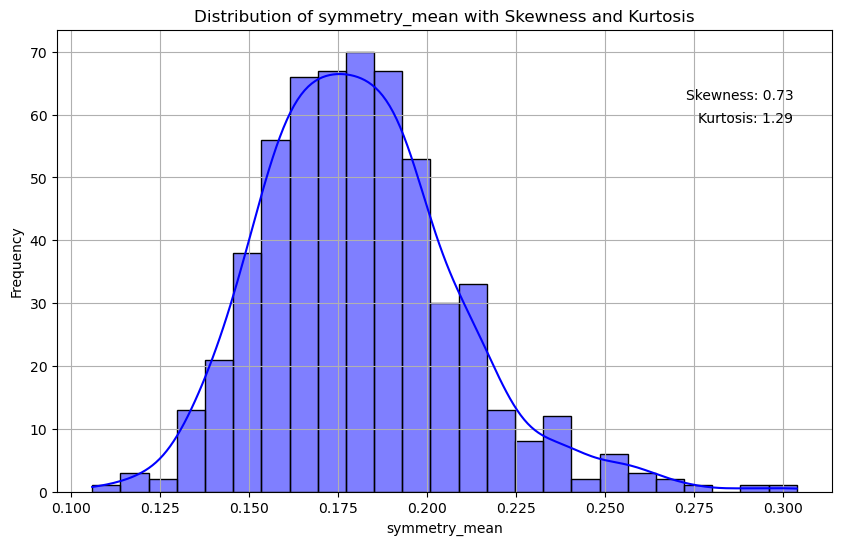

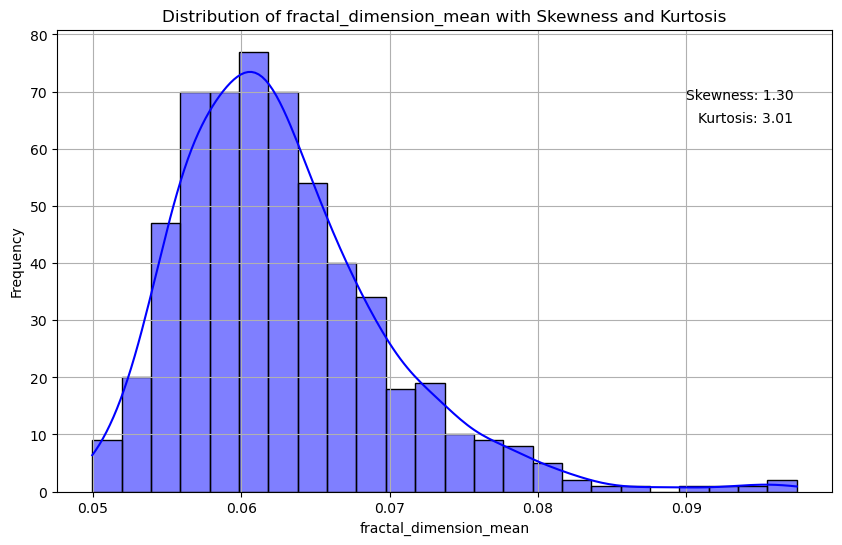

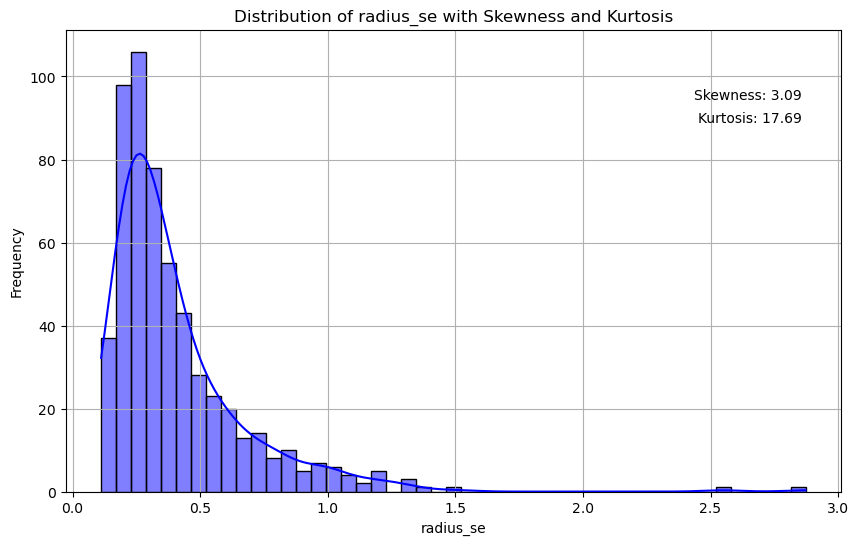

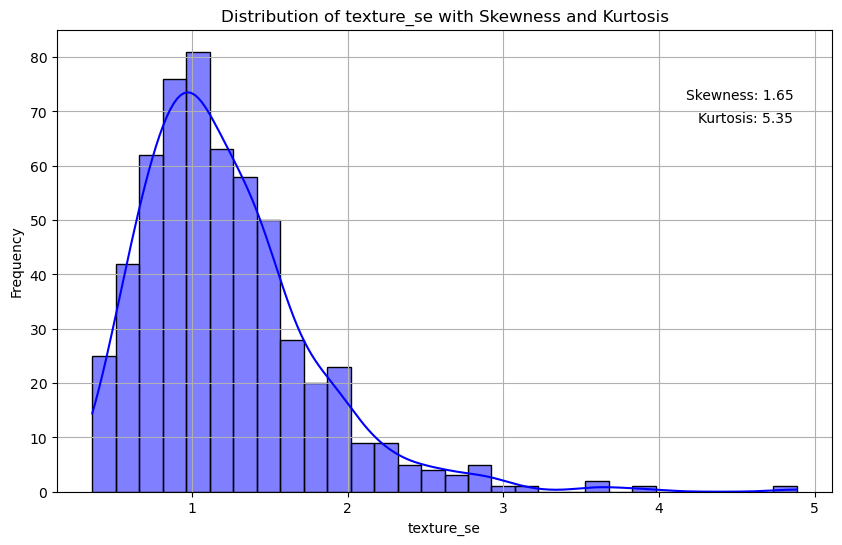

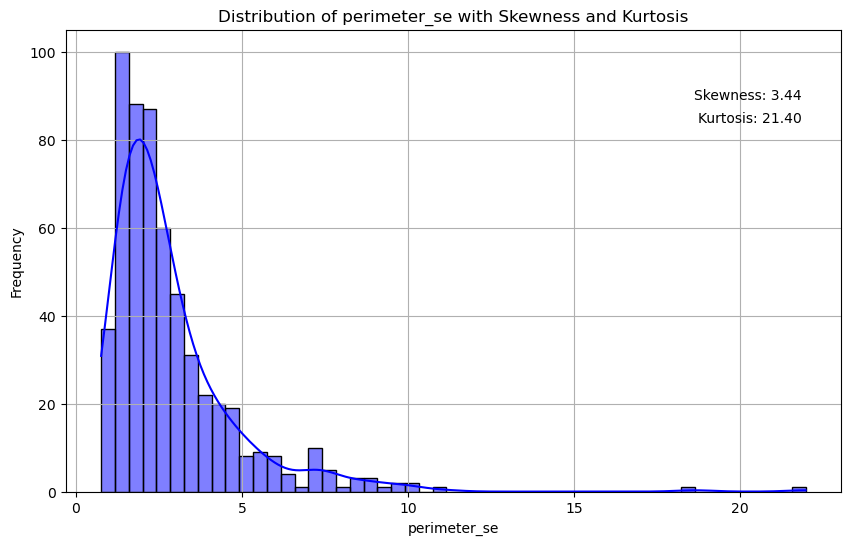

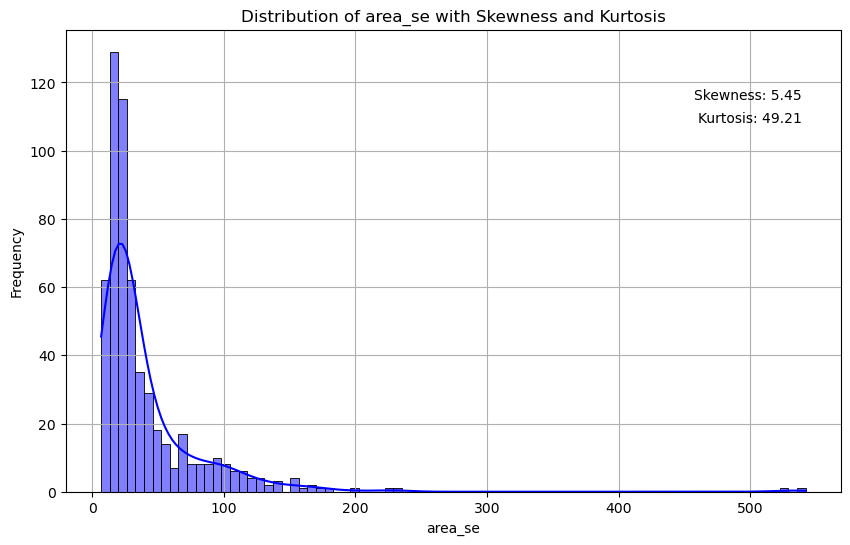

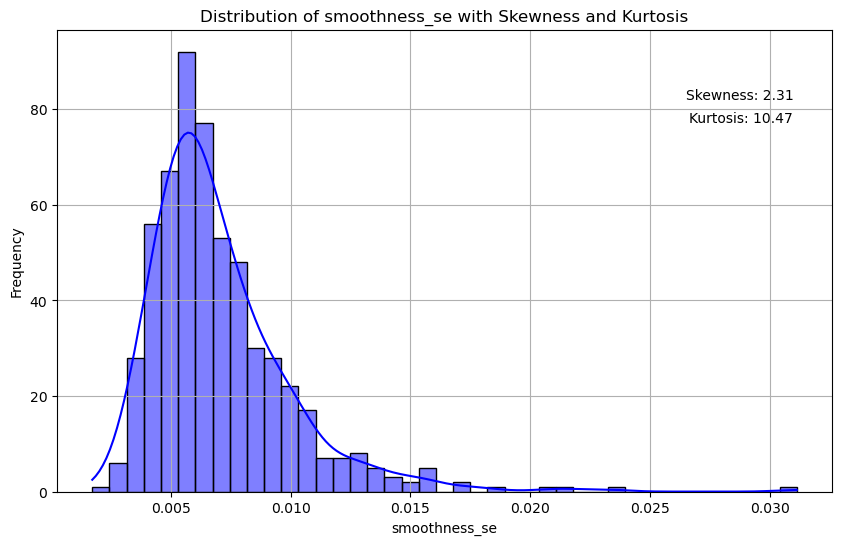

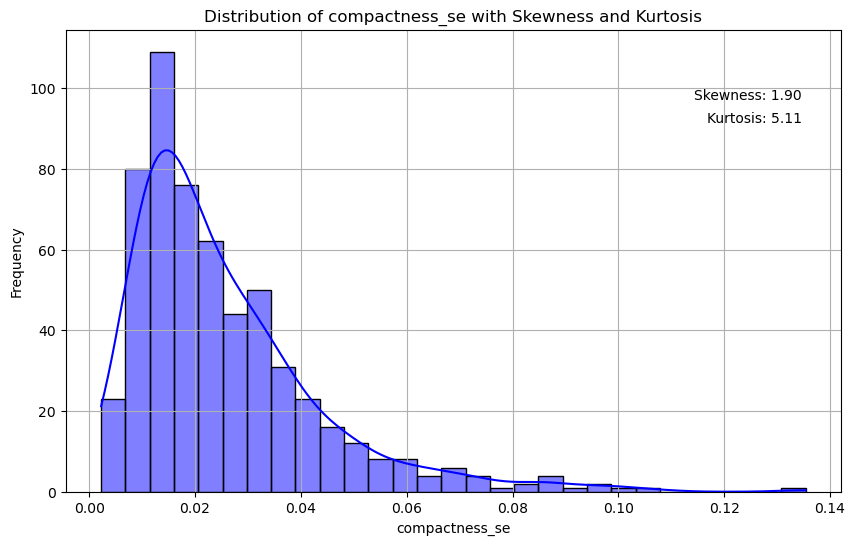

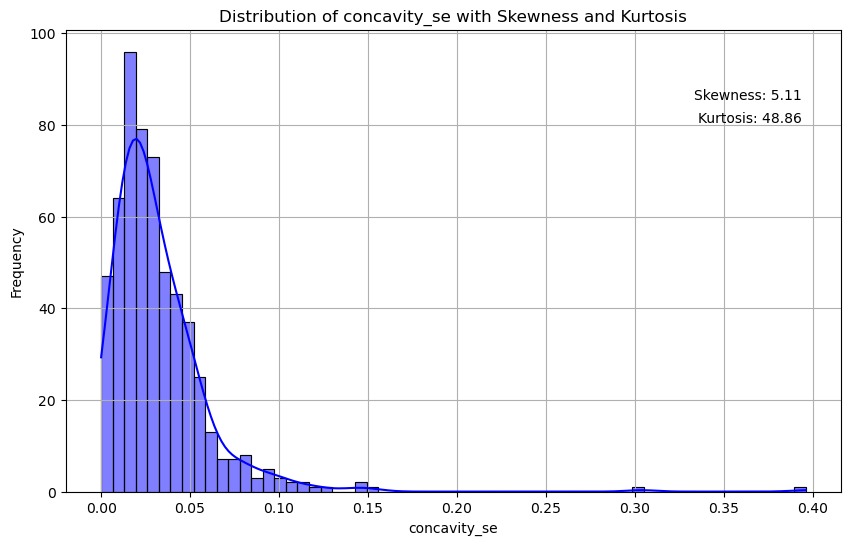

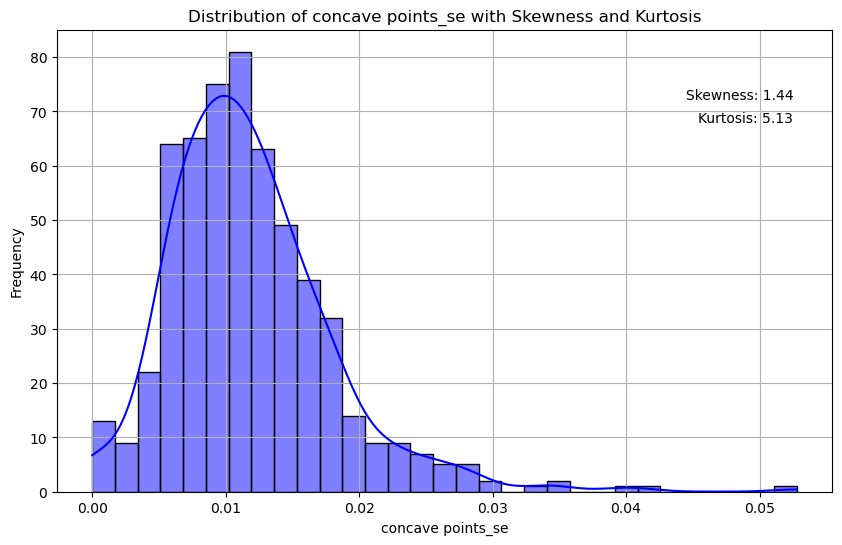

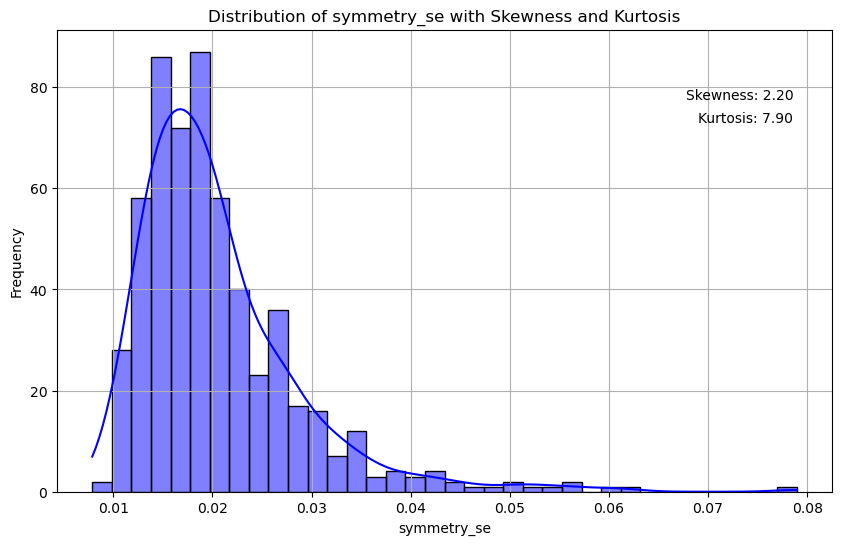

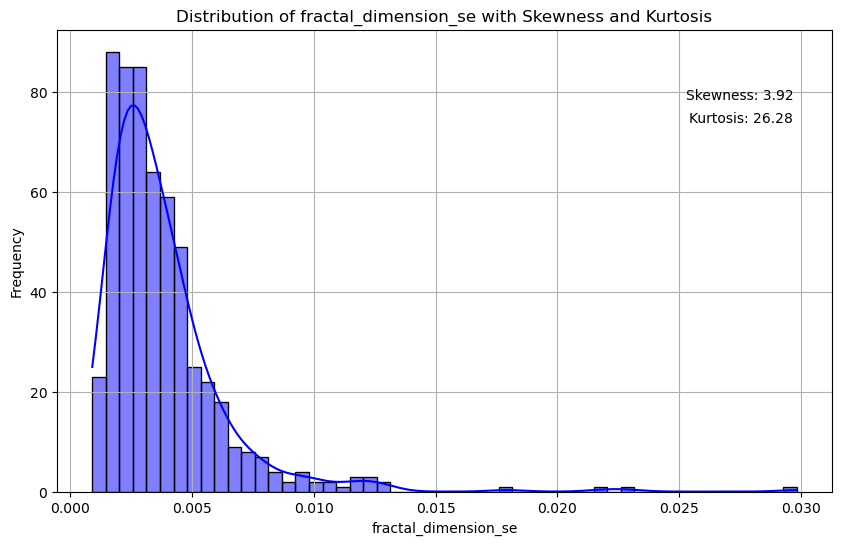

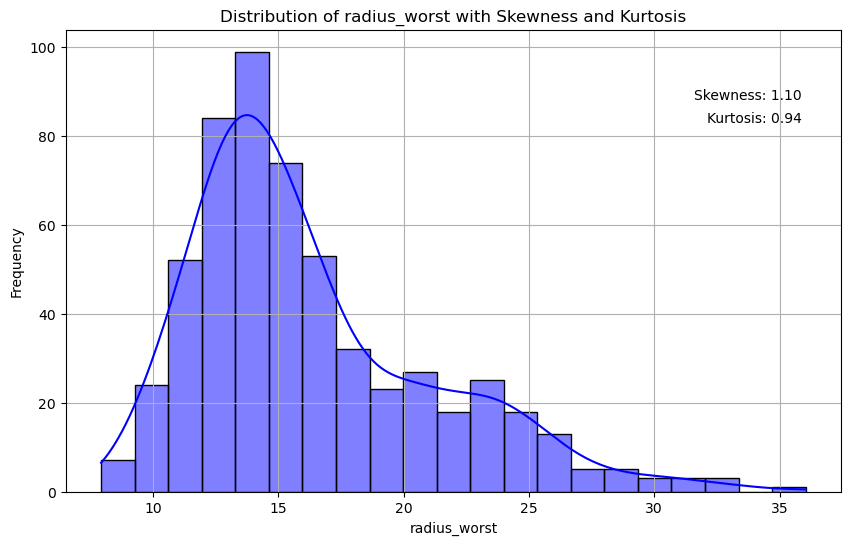

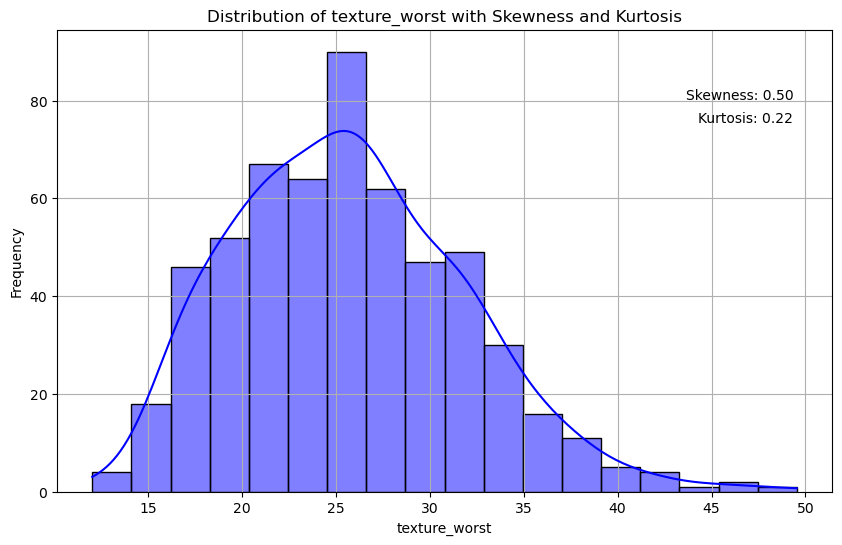

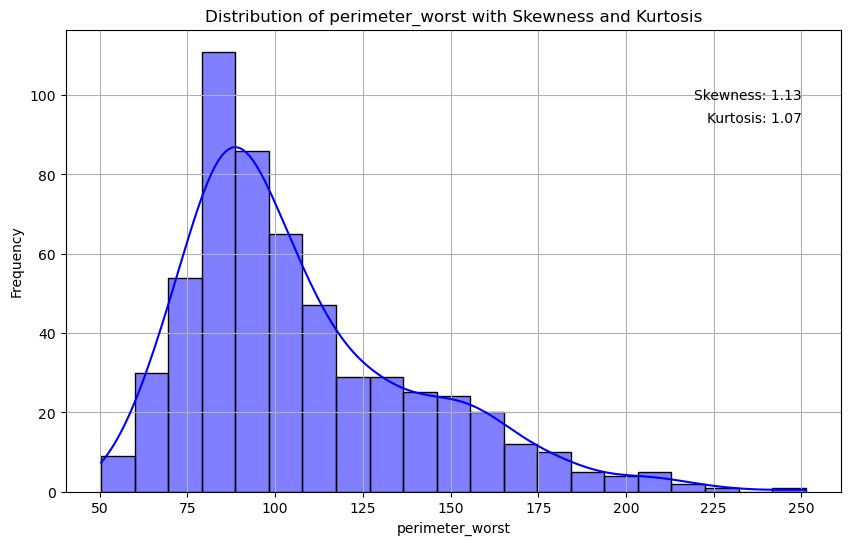

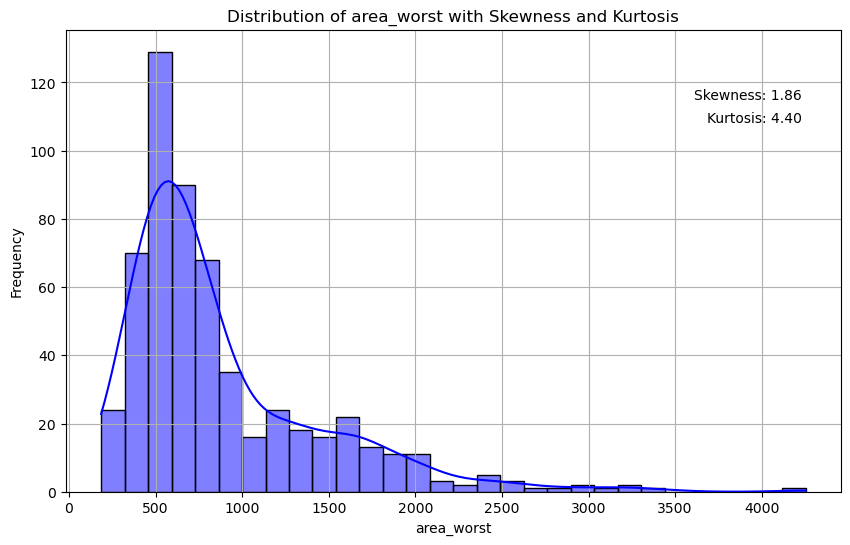

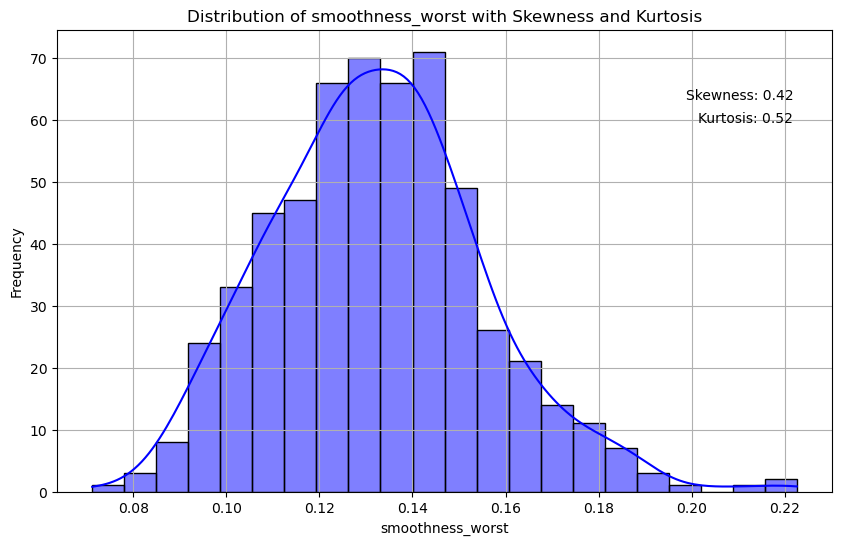

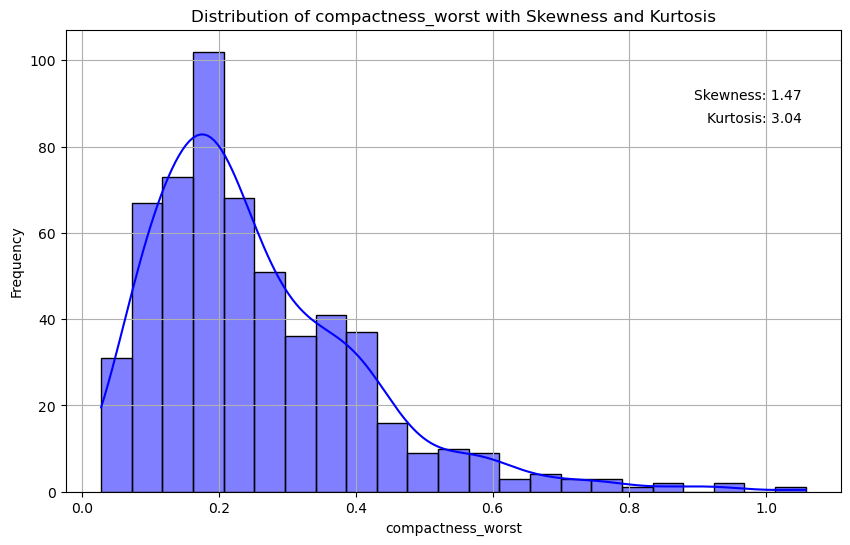

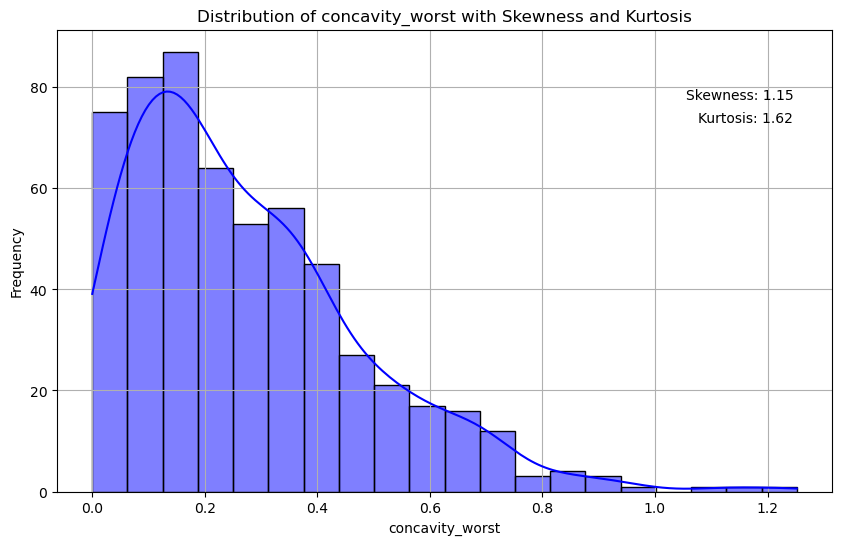

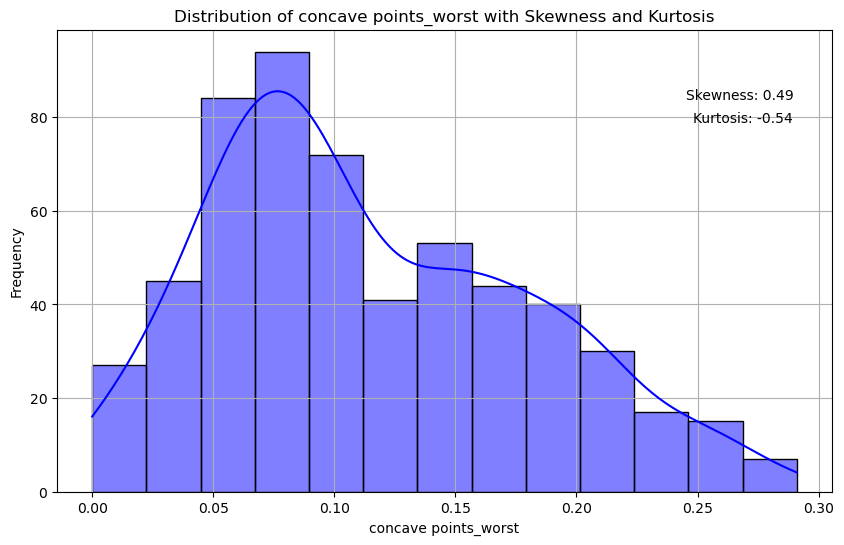

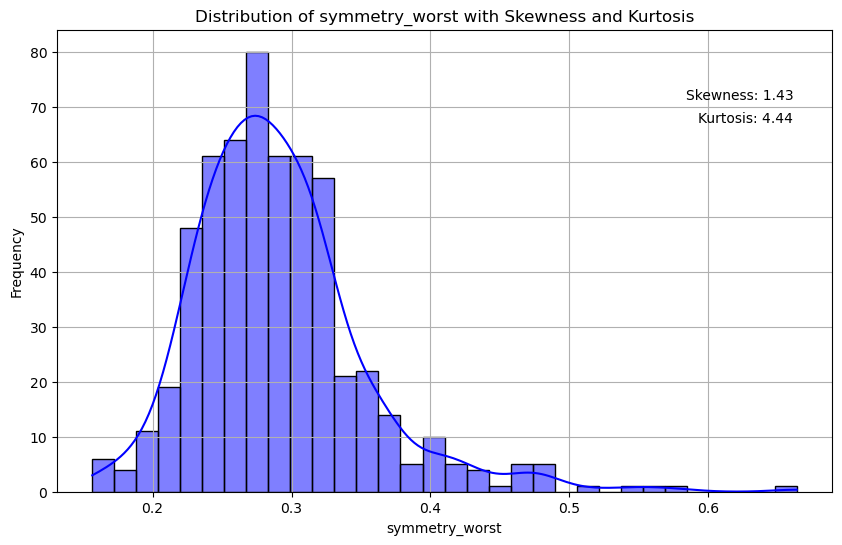

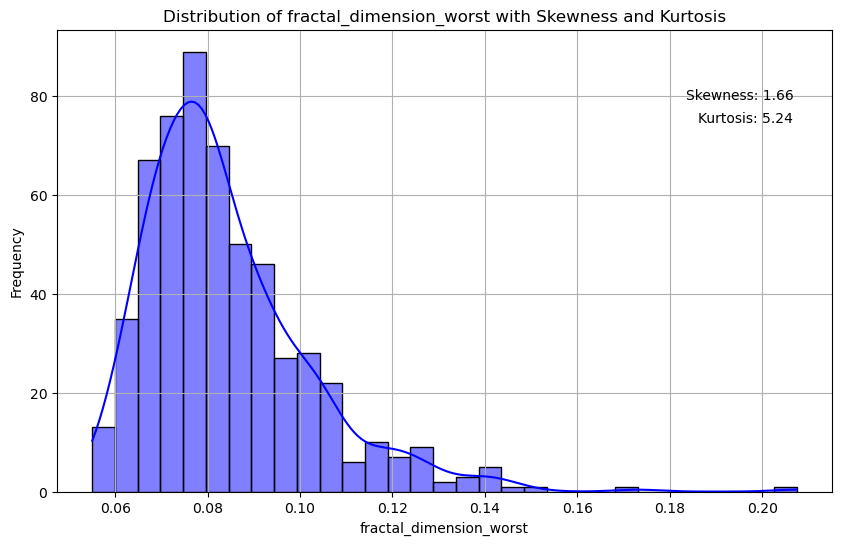

In [52]:
dist_plot(eda_df)